In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List

SEED = 42
TEST_SIZE = 0.2

In [2]:
url_jan2017_onwards = "f1765b54-a209-4718-8d38-a39237f502b3"
url_jan2015todec2016 = "1b702208-44bf-4829-b620-4615ee19b57c"
url_mar2012todec2014 = "83b2fc37-ce8c-4df4-968b-370fd818138b"
url_2000tofeb2012 = "8c00bf08-9124-479e-aeca-7cc411d884c4"
url_1990to1999 = "adbbddd3-30e2-445f-a123-29bee150a6fe"
url_base = "https://data.gov.sg/api/action/datastore_search?"

In [3]:
urls = [url_1990to1999,url_2000tofeb2012, url_mar2012todec2014, url_jan2015todec2016, url_jan2017_onwards]

In [4]:
payload = {
    'resource_id' : urls[0],
    'limit' : 100,
    'offset' : 100
}

In [5]:
import requests
response = requests.get(url_base, params=payload)
# inspecting the response
# appears that we should be expecting a total of 287196 results
print(len(response.json()['result']['records']))

100


In [6]:
response.json()

{'help': 'https://data.gov.sg/api/3/action/help_show?name=datastore_search',
 'success': True,
 'result': {'resource_id': 'adbbddd3-30e2-445f-a123-29bee150a6fe',
  'fields': [{'type': 'int4', 'id': '_id'},
   {'type': 'text', 'id': 'month'},
   {'type': 'text', 'id': 'town'},
   {'type': 'text', 'id': 'flat_type'},
   {'type': 'text', 'id': 'block'},
   {'type': 'text', 'id': 'street_name'},
   {'type': 'text', 'id': 'storey_range'},
   {'type': 'numeric', 'id': 'floor_area_sqm'},
   {'type': 'text', 'id': 'flat_model'},
   {'type': 'numeric', 'id': 'lease_commence_date'},
   {'type': 'numeric', 'id': 'resale_price'}],
  'records': [{'town': 'ANG MO KIO',
    'flat_type': '3 ROOM',
    'flat_model': 'NEW GENERATION',
    'floor_area_sqm': '68',
    'street_name': 'ANG MO KIO AVE 5',
    'resale_price': '52500',
    'month': '1990-01',
    'lease_commence_date': '1981',
    'storey_range': '07 TO 09',
    '_id': 101,
    'block': '152'},
   {'town': 'ANG MO KIO',
    'flat_type': '3 ROO

In [7]:
data = response.json()
# information is found in result, records
data['result']['records']

[{'town': 'ANG MO KIO',
  'flat_type': '3 ROOM',
  'flat_model': 'NEW GENERATION',
  'floor_area_sqm': '68',
  'street_name': 'ANG MO KIO AVE 5',
  'resale_price': '52500',
  'month': '1990-01',
  'lease_commence_date': '1981',
  'storey_range': '07 TO 09',
  '_id': 101,
  'block': '152'},
 {'town': 'ANG MO KIO',
  'flat_type': '3 ROOM',
  'flat_model': 'NEW GENERATION',
  'floor_area_sqm': '68',
  'street_name': 'ANG MO KIO AVE 4',
  'resale_price': '39000',
  'month': '1990-01',
  'lease_commence_date': '1981',
  'storey_range': '01 TO 03',
  '_id': 102,
  'block': '178'},
 {'town': 'ANG MO KIO',
  'flat_type': '3 ROOM',
  'flat_model': 'NEW GENERATION',
  'floor_area_sqm': '68',
  'street_name': 'ANG MO KIO AVE 5',
  'resale_price': '52500',
  'month': '1990-01',
  'lease_commence_date': '1981',
  'storey_range': '04 TO 06',
  '_id': 103,
  'block': '180'},
 {'town': 'ANG MO KIO',
  'flat_type': '3 ROOM',
  'flat_model': 'NEW GENERATION',
  'floor_area_sqm': '68',
  'street_name': '

In [8]:
data = data['result']['records']

In [9]:
# only pulls out 100 at a time with 11 columns
pd.DataFrame(data).shape

(100, 11)

In [10]:
payload['limit'] = 500000

In [11]:
# attempting to retrieve all records from one of the url
response = requests.get(url_base, params= payload)
data = response.json()
data = data['result']['records']
print(pd.DataFrame(data).shape)

(287096, 11)


In [12]:
import logging

def retrieve_record(url_base:str, resource_id:str, limit:int, )-> dict:
    """returns a Dataframe from the base url under the resource id
    up to the limit specified. 

    Parameters
    ----------
    url_base : str
        API endpoint
    
    resource_id : 
    
    returns: pd.DataFrame
        Records of the results
    """
    payload = {
        'resource_id' : resource_id,
        'limit' : limit 
    }
    try: 
        response = requests.get(url_base, params=payload)
        data = response.json()
        data = data['result']['records'] # data only found in records under result

        return data

    except Exception as e:
        logging.error(f'Unable to retrieve records due to {e}')

        return None

In [13]:
list_of_results = []
for url in urls:
    result = retrieve_record(url_base, url, 500000)
    list_of_results.append(result)

In [14]:
list_of_results

[[{'town': 'ANG MO KIO',
   'flat_type': '1 ROOM',
   'flat_model': 'IMPROVED',
   'floor_area_sqm': '31',
   'street_name': 'ANG MO KIO AVE 1',
   'resale_price': '9000',
   'month': '1990-01',
   'lease_commence_date': '1977',
   'storey_range': '10 TO 12',
   '_id': 1,
   'block': '309'},
  {'town': 'ANG MO KIO',
   'flat_type': '1 ROOM',
   'flat_model': 'IMPROVED',
   'floor_area_sqm': '31',
   'street_name': 'ANG MO KIO AVE 1',
   'resale_price': '6000',
   'month': '1990-01',
   'lease_commence_date': '1977',
   'storey_range': '04 TO 06',
   '_id': 2,
   'block': '309'},
  {'town': 'ANG MO KIO',
   'flat_type': '1 ROOM',
   'flat_model': 'IMPROVED',
   'floor_area_sqm': '31',
   'street_name': 'ANG MO KIO AVE 1',
   'resale_price': '8000',
   'month': '1990-01',
   'lease_commence_date': '1977',
   'storey_range': '10 TO 12',
   '_id': 3,
   'block': '309'},
  {'town': 'ANG MO KIO',
   'flat_type': '1 ROOM',
   'flat_model': 'IMPROVED',
   'floor_area_sqm': '31',
   'street_nam

In [15]:
data = pd.DataFrame(list_of_results[0])

In [16]:
len(list_of_results[2])

52203

In [17]:
for result in list_of_results:
    rows = 0
    data = pd.DataFrame(result)
    rows += data.shape[0]
    print(f'Columns result is {data.columns}')

print(f'Total rows is {rows}')

Columns result is Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', '_id',
       'block'],
      dtype='object')
Columns result is Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', '_id',
       'block'],
      dtype='object')
Columns result is Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', '_id',
       'block'],
      dtype='object')
Columns result is Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'remaining_lease', 'lease_commence_date',
       'storey_range', '_id', 'block'],
      dtype='object')
Columns result is Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'remaining_lease

I am unable to merge everything at a go since there is an additional column "remaining lease" in some data

however the remaining lease should be able to be calculated from the difference between 99 years 

(total lease) - (date of transaction - lease commence date)

so the remaining_lease will be dropped.

In [18]:
df_part1 = pd.concat((
pd.DataFrame(list_of_results[0]),
pd.DataFrame(list_of_results[1]),
pd.DataFrame(list_of_results[2])), axis=0)

In [19]:
df_part2 = pd.concat((
pd.DataFrame(list_of_results[3]),
pd.DataFrame(list_of_results[4])), axis=0)

In [20]:
df_part1.shape

(709050, 11)

In [21]:
df_part1.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', '_id',
       'block'],
      dtype='object')

In [22]:
df_part2.shape

(183855, 12)

In [23]:
df_part2.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'remaining_lease', 'lease_commence_date',
       'storey_range', '_id', 'block'],
      dtype='object')

In [24]:
# I changed my mind I will create the remaining_lease instead of dropping the remaining_lease from
# the other dataframe

In [25]:
df_part1.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,9000,1990-01,1977,10 TO 12,1,309
1,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,04 TO 06,2,309
2,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,8000,1990-01,1977,10 TO 12,3,309
3,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,07 TO 09,4,309
4,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216


In [26]:
df_part1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709050 entries, 0 to 52202
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   town                 709050 non-null  object
 1   flat_type            709050 non-null  object
 2   flat_model           709050 non-null  object
 3   floor_area_sqm       709050 non-null  object
 4   street_name          709050 non-null  object
 5   resale_price         709050 non-null  object
 6   month                709050 non-null  object
 7   lease_commence_date  709050 non-null  object
 8   storey_range         709050 non-null  object
 9   _id                  709050 non-null  int64 
 10  block                709050 non-null  object
dtypes: int64(1), object(10)
memory usage: 64.9+ MB


In [27]:
df_part1['remaining_lease'] = 99 - (pd.to_datetime(df_part1['month']).dt.year - df_part1['lease_commence_date'].astype(int) )

In [28]:
df_part1.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,remaining_lease
0,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,9000,1990-01,1977,10 TO 12,1,309,86
1,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,04 TO 06,2,309,86
2,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,8000,1990-01,1977,10 TO 12,3,309,86
3,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,07 TO 09,4,309,86
4,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216,85


In [29]:
df_part2.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,3 ROOM,Improved,60,ANG MO KIO AVE 4,255000,2015-01,70,1986,07 TO 09,1,174
1,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,275000,2015-01,65,1981,01 TO 03,2,541
2,ANG MO KIO,3 ROOM,New Generation,69,ANG MO KIO AVE 4,285000,2015-01,64,1980,01 TO 03,3,163
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,290000,2015-01,63,1979,01 TO 03,4,446
4,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,290000,2015-01,64,1980,07 TO 09,5,557


In [30]:
# Rearranging cols so that the concatation will work later
df = df_part1[['remaining_lease']+ [col for col in df_part1.columns if col != 'remaining_lease']]
df2 = df_part2[['remaining_lease']+ [col for col in df_part2.columns if col != 'remaining_lease']]

In [31]:
df.head()

,remaining_lease,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block
0,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,9000,1990-01,1977,10 TO 12,1,309
1,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,04 TO 06,2,309
2,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,8000,1990-01,1977,10 TO 12,3,309
3,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,07 TO 09,4,309
4,85,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216


In [32]:
df2.head()

,remaining_lease,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block
0,70,ANG MO KIO,3 ROOM,Improved,60,ANG MO KIO AVE 4,255000,2015-01,1986,07 TO 09,1,174
1,65,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,275000,2015-01,1981,01 TO 03,2,541
2,64,ANG MO KIO,3 ROOM,New Generation,69,ANG MO KIO AVE 4,285000,2015-01,1980,01 TO 03,3,163
3,63,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,290000,2015-01,1979,01 TO 03,4,446
4,64,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,290000,2015-01,1980,07 TO 09,5,557


In [33]:
df_combined = pd.concat((df, df2))

In [34]:
df_combined.shape

(892905, 12)

In [35]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892905 entries, 0 to 146701
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   remaining_lease      892905 non-null  object
 1   town                 892905 non-null  object
 2   flat_type            892905 non-null  object
 3   flat_model           892905 non-null  object
 4   floor_area_sqm       892905 non-null  object
 5   street_name          892905 non-null  object
 6   resale_price         892905 non-null  object
 7   month                892905 non-null  object
 8   lease_commence_date  892905 non-null  object
 9   storey_range         892905 non-null  object
 10  _id                  892905 non-null  int64 
 11  block                892905 non-null  object
dtypes: int64(1), object(11)
memory usage: 88.6+ MB


## Amend Selected Street Names due to mapping logic

`MARINE CRES` to `MARINE CRESCENT VILLE` as `marine cresc` will pick up `SEMBCORP MARINE TUAS CRESCENT YARD`

In [36]:
df_test = df_combined['street_name'].copy(deep=True)

In [37]:
df_test[df_test.str.contains('MARINE CRES')]

1039      MARINE CRES
1046      MARINE CRES
1047      MARINE CRES
1048      MARINE CRES
1049      MARINE CRES
             ...     
144684    MARINE CRES
144692    MARINE CRES
144693    MARINE CRES
146332    MARINE CRES
146333    MARINE CRES
Name: street_name, Length: 2527, dtype: object

In [38]:
df_test_edited = df_combined['street_name'].where(df_combined['street_name']!='MARINE CRES','MARINE CRESCENT VILLE')

In [39]:
df_test_edited[df_test_edited.str.contains('MARINE CRES')]

1039      MARINE CRESCENT VILLE
1046      MARINE CRESCENT VILLE
1047      MARINE CRESCENT VILLE
1048      MARINE CRESCENT VILLE
1049      MARINE CRESCENT VILLE
                  ...          
144684    MARINE CRESCENT VILLE
144692    MARINE CRESCENT VILLE
144693    MARINE CRESCENT VILLE
146332    MARINE CRESCENT VILLE
146333    MARINE CRESCENT VILLE
Name: street_name, Length: 2527, dtype: object

In [40]:
df_combined['street_name'] = df_combined['street_name'].where(df_combined['street_name']!='MARINE CRES','MARINE CRESCENT VILLE') 

In [41]:
def retrieve_records(url_base:str, urls: List[str],limit:int)->pd.DataFrame:
    """Returns the entire list of url as a pandas dataframe.
    If there is a link that is broken, it will return None
    Will also add in an additional column of remaining lease into the 
    years that do not have it.

    Args:
        url_base (str): API endpoint for data.gov.sg
        urls (List[str]): list of url
        limit (int): Limits the amount of records being retrieved 
        in each given year

    Returns:
        pd.DataFrame: Compilation of the entire record
    """
    list_of_results = []
    for url in urls:
        result = retrieve_record(url_base, url, limit)
        try:
            list_of_results.append(result)

        except Exception as e:

            logging.error(f'Unable to retrieve records due to {e}')
            return None


    # 2017 to 2014 records with additional column 'remaining lease'
    df_part1 = pd.concat((
        pd.DataFrame(list_of_results[0]),
        pd.DataFrame(list_of_results[1]),
        pd.DataFrame(list_of_results[2])), axis=0)
    # 2014 and before 
    df_part2 = pd.concat((
        pd.DataFrame(list_of_results[3]),
        pd.DataFrame(list_of_results[4])), axis=0)

    df_part1['remaining_lease'] = 99 - (pd.to_datetime(df_part1['month']).dt.year - df_part1['lease_commence_date'].astype(int) )

    # Rearranging cols so that the concatation will work later
    df = df_part1[['remaining_lease']+ [col for col in df_part1.columns if col != 'remaining_lease']]
    df2 = df_part2[['remaining_lease']+ [col for col in df_part2.columns if col != 'remaining_lease']]

    df_combined = pd.concat((df, df2))

    return df_combined

In [42]:
test_df_combined = retrieve_records(url_base, urls, 500000)

In [43]:
df_combined.equals(test_df_combined)

False

# Feature Engineering

## Getting MRT details

In [44]:
# Now we will try to extract the unique values of the HDB flats and append the geo location

In [45]:
df_combined.head()

,remaining_lease,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block
0,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,9000,1990-01,1977,10 TO 12,1,309
1,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,04 TO 06,2,309
2,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,8000,1990-01,1977,10 TO 12,3,309
3,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,07 TO 09,4,309
4,85,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216


In [46]:
df_combined['address'] = df_combined['block'] + " " + df_combined['street_name']

In [47]:
unique_address = df_combined['address'].unique()

In [48]:
unique_address

array(['309 ANG MO KIO AVE 1', '216 ANG MO KIO AVE 1',
       '211 ANG MO KIO AVE 3', ..., '326C SUMANG WALK',
       '494J TAMPINES ST 45', '676A YISHUN RING RD'], dtype=object)

In [49]:
# Calling onemap sg api is really slow. This is the solution : https://discuss.onemap.sg/t/search-api-returning-response-404-after-a-while/1710/4

In [50]:
import requests

import socket
import requests.packages.urllib3.util.connection as urllib3_cn
 
def allowed_gai_family():
    family = socket.AF_INET    # force IPv4
    return family
 
urllib3_cn.allowed_gai_family = allowed_gai_family

In [51]:
ONE_MAP_API_ADDRESS = "https://developers.onemap.sg/commonapi/search"
payload = {'searchVal': '216 ANG MO KIO AVE 1',
'returnGeom': 'Y',
'getAddrDetails': 'Y',
'pageNum':1}
res= requests.get(ONE_MAP_API_ADDRESS, params=payload)

In [52]:
res.json()

{'found': 1,
 'totalNumPages': 1,
 'pageNum': 1,
 'results': [{'SEARCHVAL': 'ANG MO KIO 22',
   'BLK_NO': '216',
   'ROAD_NAME': 'ANG MO KIO AVENUE 1',
   'BUILDING': 'ANG MO KIO 22',
   'ADDRESS': '216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPORE 560216',
   'POSTAL': '560216',
   'X': '28911.0522399368',
   'Y': '38692.6167905722',
   'LATITUDE': '1.36619678831054',
   'LONGITUDE': '103.841505011903',
   'LONGTITUDE': '103.841505011903'}]}

In [53]:
res.json()['results'][0]['ADDRESS']

'216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPORE 560216'

In [54]:
# inside the results we have lat, long, full address and postal

In [55]:
from typing import List

def return_geo_many_address(one_map_url:str, address_list:List[str])->List[str]:
    """Returns addresses. Calls `return_geo_one_address` for each address and returns
    a List

    Args:
        one_map_url (str): base api endpoint of the one map sg
        address_list (List[str]): a list of address

    Returns:
        List[str]: all of the address with full address, lat and long
    """
    geo_details = []
    for address in address_list:

        res = return_geo_one_address(one_map_url,address)

        geo_details.append([res['address'], res['lat'], res['long']])
    
    return geo_details

In [56]:
def return_geo_one_address(one_map_url:str, query:str)->dict:
    """Return geo details of one address given an address
    It is known to not perform well if additional information is given
    like street.
    Takes only the first result that is given from the API.
    For MRT, it must be <station name> <MRT/LRT Station> (station code)
    for example Ang Mo kio MRT station (NS24)
    otherwise there might be zero or inaccurate result

    Args:
        one_map_url (str): base api endpoint of the one map sg
        query (str): address e.g 325 Ang Mo Kio

    Returns:
        dict: address with lat, long and full address
    """
    payload = {'searchVal': query,
    'returnGeom': 'Y',
    'getAddrDetails': 'Y',
    'pageNum':1}

    res= requests.get(one_map_url, params=payload)

    try:
        res = res.json()['results'][0] # get only the first result
        full_add = res['ADDRESS']
        lat = float(res['LATITUDE'])
        long = float(res['LONGITUDE'])
        address = {'address': full_add, 'lat': lat, 'long': long}
    except Exception as e:
        logging.debug(f'No results for {query} due to message: {e}')
        address = {'address': 'na', 'lat': 'na', 'long': 'na'}
    
    return address

In [57]:
unique_address[:10][1]

'216 ANG MO KIO AVE 1'

In [58]:
# This cell is not optimial since the records are dynamic
import pickle
try:
    with open('geo_details','rb') as f:
        geo_details = pickle.load(f)
except:
    # Takes about 13 mins
    geo_details = return_geo_many_address(ONE_MAP_API_ADDRESS , unique_address)
    with open('geo_details','wb') as f:
        pickle.load(geo_details,f)

In [59]:
geo_details = return_geo_many_address(ONE_MAP_API_ADDRESS , unique_address)

In [60]:
len(geo_details)

9707

In [61]:
geo_details[9704]

['326C SUMANG WALK PUNGGOL VUE SINGAPORE 823326',
 1.41240459366921,
 103.900177817489]

In [62]:
unique_address_geo = []

for idx, address in enumerate(unique_address):
    try:
        unique_address_geo.append([address, geo_details[idx][0],geo_details[idx][1],geo_details[idx][2]])
    except Exception as e:
        print(f"Unable to append id {idx} with address: {address} due to {e}")

In [63]:
unique_address_geo_pd = pd.DataFrame(unique_address_geo)

In [64]:
unique_address_geo_pd.columns = ('address','full_address','lat','long')

In [65]:
# why are these address not found in onemapsg?
print(f'Number of address with no geo data {len(unique_address_geo_pd[unique_address_geo_pd["full_address"]=="na"])}')
unique_address_geo_pd[unique_address_geo_pd['full_address']=='na'].sample(5)

Number of address with no geo data 121


,address,full_address,lat,long
1263,402 CLEMENTI AVE 1,na,na,na
1224,107 DEPOT RD,na,na,na
2034,5 BUANGKOK STH FARMWAY 1,na,na,na
715,20 UPP BOON KENG RD,na,na,na
675,220 BOON LAY AVE,na,na,na


In [66]:
# apparently verifying address is a business. I can see how this is a good service especially for delivery companies
# they should not be sending parcels to false addresses and they should be able to check whether an address
# is valid before confirming the order.
# https://www.easypost.com/singapore-address-verification
# https://www.sglocate.com/


In [67]:
mrt_file = "https://datamall.lta.gov.sg/content/dam/datamall/datasets/PublicTransportRelated/Train%20Station%20Codes%20and%20Chinese%20Names.zip"

In [68]:
r = requests.get(mrt_file)

In [69]:
import zipfile
from io import BytesIO

In [70]:
z = zipfile.ZipFile(BytesIO(r.content))

In [71]:
train_file_name = "Train Station Codes and Chinese Names.xls"

In [72]:
archive = zipfile.ZipFile(BytesIO(r.content), 'r')
imgdata = pd.read_excel(archive.read(train_file_name))

In [73]:
imgdata

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North-South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North-South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线
4,NS5,Yew Tee,油池,North-South Line,南北线
...,...,...,...,...,...
200,TE17,Outram Park,欧南园,Thomson-East Coast Line,汤申-东海岸线
201,TE18,Maxwell,麦士威,Thomson-East Coast Line,汤申-东海岸线
202,TE19,Shenton Way,珊顿道,Thomson-East Coast Line,汤申-东海岸线
203,TE20,Marina Bay,滨海湾,Thomson-East Coast Line,汤申-东海岸线


In [74]:
z.extractall()

In [75]:
pd.read_excel(train_file_name)

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North-South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North-South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线
4,NS5,Yew Tee,油池,North-South Line,南北线
...,...,...,...,...,...
200,TE17,Outram Park,欧南园,Thomson-East Coast Line,汤申-东海岸线
201,TE18,Maxwell,麦士威,Thomson-East Coast Line,汤申-东海岸线
202,TE19,Shenton Way,珊顿道,Thomson-East Coast Line,汤申-东海岸线
203,TE20,Marina Bay,滨海湾,Thomson-East Coast Line,汤申-东海岸线


In [76]:
stations_list = pd.read_excel(train_file_name).loc[:,['stn_code', 'mrt_station_english']]

In [77]:
stations_list

,stn_code,mrt_station_english
0,NS1,Jurong East
1,NS2,Bukit Batok
2,NS3,Bukit Gombak
3,NS4,Choa Chu Kang
4,NS5,Yew Tee
...,...,...
200,TE17,Outram Park
201,TE18,Maxwell
202,TE19,Shenton Way
203,TE20,Marina Bay


In [78]:
stations_list

,stn_code,mrt_station_english
0,NS1,Jurong East
1,NS2,Bukit Batok
2,NS3,Bukit Gombak
3,NS4,Choa Chu Kang
4,NS5,Yew Tee
...,...,...
200,TE17,Outram Park
201,TE18,Maxwell
202,TE19,Shenton Way
203,TE20,Marina Bay


In [79]:
def download_mrt_excelsheet(url:str = "https://datamall.lta.gov.sg/content/dam/datamall/datasets/PublicTransportRelated/Train%20Station%20Codes%20and%20Chinese%20Names.zip"):
    r = requests.get(url)
    z = zipfile.ZipFile(BytesIO(r.content))
    z.extractall()
    

In [80]:
def extract_mrt_excelsheet(default_file_name:str = "Train Station Codes and Chinese Names.xls")->pd.DataFrame:
    download_mrt_excelsheet()
    return pd.read_excel(default_file_name)

In [81]:
stations = extract_mrt_excelsheet()

In [82]:
stations

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North-South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North-South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线
4,NS5,Yew Tee,油池,North-South Line,南北线
...,...,...,...,...,...
200,TE17,Outram Park,欧南园,Thomson-East Coast Line,汤申-东海岸线
201,TE18,Maxwell,麦士威,Thomson-East Coast Line,汤申-东海岸线
202,TE19,Shenton Way,珊顿道,Thomson-East Coast Line,汤申-东海岸线
203,TE20,Marina Bay,滨海湾,Thomson-East Coast Line,汤申-东海岸线


In [83]:
stations = stations.loc[:,['stn_code','mrt_station_english']]

In [84]:
stations

,stn_code,mrt_station_english
0,NS1,Jurong East
1,NS2,Bukit Batok
2,NS3,Bukit Gombak
3,NS4,Choa Chu Kang
4,NS5,Yew Tee
...,...,...
200,TE17,Outram Park
201,TE18,Maxwell
202,TE19,Shenton Way
203,TE20,Marina Bay


In [85]:
def extract_mrt_excelsheet(mrt_api:str, mrt_excel_file:str)->pd.DataFrame:
    """Reads the zip file of the MRT train names in memory and
    returns a pd Dataframe of the data

    Args:
        mrt_api (str): api endpoint of the lta datamall for train names
        mrt_excel_file (str): name of the excel file

    Returns:
        pd.DataFrame: pd dataframe of the excel file
    """
    try:
        r = requests.get(mrt_api)
        z = zipfile.ZipFile(BytesIO(r.content), 'r')
        # we only need 2 columns
        data = pd.read_excel(z.read(mrt_excel_file)).loc[:,['stn_code', 'mrt_station_english']] 
        return data
    except Exception as e:
        logging.error(f'Unable to extract MRT excelsheet. Error {e}')

In [86]:
test_stations = extract_mrt_excelsheet(mrt_file, train_file_name)

In [87]:
stations.equals(test_stations)

True

In [88]:
stations[stations['stn_code'].str.contains('EW') ]

,stn_code,mrt_station_english
27,EW1,Pasir Ris
28,EW2,Tampines
29,EW3,Simei
30,EW4,Tanah Merah
31,EW5,Bedok
32,EW6,Kembangan
33,EW7,Eunos
34,EW8,Paya Lebar
35,EW9,Aljunied
36,EW10,Kallang


In [89]:
station_codes = set([station_code[:2] for station_code in stations['stn_code']])

In [90]:
station_codes

{'BP',
 'CC',
 'CE',
 'CG',
 'DT',
 'EW',
 'NE',
 'NS',
 'PE',
 'PT',
 'PW',
 'SE',
 'ST',
 'SW',
 'TE'}

In [91]:
station_name = 'jurong east'
train = 'mrt station'
station_code = 'EW24'
payload = {'searchVal': f"{station_name} {train} ({station_code}) ",
'returnGeom': 'Y',
'getAddrDetails': 'Y',
'pageNum':1}
ONE_MAP_API_ADDRESS = "https://developers.onemap.sg/commonapi/search"

In [92]:
station_name in requests.get(ONE_MAP_API_ADDRESS, params=payload).json()['results'][0]['SEARCHVAL'].lower()

True

In [93]:
def return_mrt_with_geo(one_map_url:str,stations:pd.DataFrame)->pd.DataFrame:
    """ returns the full address along with the lat and long of the MRT station.
    This set of data is effectively the excel spreadsheet with relevant columns only
    and the geo location and full name appended on it.

    Function will attempt to return the correct address by checking against the station
    code associated with the mrt station
    """

    geo_details = {}
    for station in stations.values:
        station_code = station[0].lower()
        station_name = station[1].lower()
        for train in ['mrt station', 'lrt station']:
            payload = {'searchVal': f"{station_name} {train} ({station_code}) ",
            'returnGeom': 'Y',
            'getAddrDetails': 'Y',
            'pageNum':1}

            res= requests.get(one_map_url, params=payload)

            try:
                res = res.json()['results'][0] # get only the first result
                full_add = res['ADDRESS']
                lat = float(res['LATITUDE'])
                long = float(res['LONGITUDE'])
                
                # only keep the address if the search val matches and there is nothing in the result
                if (station_name in res['SEARCHVAL'].lower()) and (station_name not in geo_details): 
                    entry = {'stn_code': station_code, 'address': full_add, 'lat': lat, 'long': long}
                    geo_details[station_name] = entry
                    
            except Exception as e:
                logging.debug(f"Search for {station_name} {train} skipped")
    
    stations_pd = pd.DataFrame(geo_details).T.reset_index().rename(columns={'index':'station_name'})

    return stations_pd

In [94]:
stations_pd = return_mrt_with_geo(ONE_MAP_API_ADDRESS ,stations)

In [95]:
stations_pd

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [96]:
# So the difficult part about integrating this information is that the mrt stations are not built at the same time
# take for example the green line is built in the 1987, lrt is in 1999, circle line 2009
# to complicate matters, some lines like the circle line are opened in stages (extensions included).
# for simplicity I will take the first result of the MRT location and only include the MRT if it was announced after that

In [97]:
# Quite a number of lines!
set([station_code[:2] for station_code in stations_pd['stn_code']])

{'bp', 'cc', 'ce', 'cg', 'dt', 'ew', 'ne', 'ns', 'pe', 'pw', 'se', 'sw', 'te'}

Announcement or opened Dates (info from https://www.sgtrains.com/network.html)

MRTs
- DT 2005 
- EW 1987 
- CC 2009
- NS 1987
- NE 2003

LRTs
- BP 1999
- SE 2003 
- SW 2003
- PE 2005
- PW 2005

I will factor the calculation for the MRTs for NS and EW line pre 2000 and everything else 2000 onwards

## Distance between MRT and flats and nearest MRT 

In [98]:
_,_,sample_flat_lat, sample_flat_long = unique_address_geo_pd.iloc[1,:]

In [99]:
sample_flat_coor = [float(sample_flat_lat), float(sample_flat_long)]

In [100]:
import haversine.haversine as haversine

In [101]:
home_address = return_geo_one_address(ONE_MAP_API_ADDRESS, '325 Ang Mo Kio Ave 3')

In [102]:
mrt_address = return_geo_one_address(ONE_MAP_API_ADDRESS, 'Ang Mo kio MRT station (NS16)')

In [103]:
haversine([home_address['lat'],home_address['long']], (mrt_address['lat'] , mrt_address['long']))

0.37315066337697594

In [104]:
# need to calculate the minimum distance between a location and all other mrt. Return the minimum distance along with the station name

In [105]:
unique_address_geo_pd_valid = unique_address_geo_pd[unique_address_geo_pd['full_address'] != 'na']

In [106]:
unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\2501567114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\2501567114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')


In [107]:
stations_pd

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [108]:
import numpy as np

def return_closest_mrt_distance(coor:List[float], stations:pd.DataFrame)->dict:
    """ with one set of coordinates (lat, long) returns the minimum distance
    to the MRT along with the MRT name
    """
    res = np.zeros((len(stations),1))
    for idx, station in enumerate(stations.values):
        station_coor = (station[3], station[4])
        res[idx] = haversine(coor, (station_coor))

    min_distance_idx = np.argmin(res)
    
    return {'closest_mrt': stations.values[min_distance_idx][0],'distance': round(res[min_distance_idx][0],3)}
        

In [109]:
# Seems right
return_closest_mrt_distance((home_address['lat'],home_address['long']), stations_pd)

{'closest_mrt': 'ang mo kio', 'distance': 0.373}

In [110]:
test_address = return_geo_one_address(ONE_MAP_API_ADDRESS, '658D Jurong West')

In [111]:
# seems right
return_closest_mrt_distance((test_address['lat'],test_address['long']), stations_pd)

{'closest_mrt': 'pioneer', 'distance': 0.384}

In [112]:
res = []
for address in unique_address_geo_pd_valid.values:
    lat,long = address[2] , address[3]
    mrt = return_closest_mrt_distance((lat,long), stations_pd)
    res.append([mrt['closest_mrt'], mrt['distance']])

In [113]:
len(unique_address_geo_pd_valid)

9586

In [114]:
len(res)

9586

In [115]:
unique_address_geo_pd_valid.reset_index(drop=True)

,address,full_address,lat,long
0,216 ANG MO KIO AVE 1,216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPOR...,1.366197,103.841505
1,211 ANG MO KIO AVE 3,211 ANG MO KIO AVENUE 3 SINGAPORE 560211,1.369197,103.841667
2,202 ANG MO KIO AVE 3,202 ANG MO KIO AVENUE 3 ANG MO KIO VIEW SINGAP...,1.368446,103.844516
3,235 ANG MO KIO AVE 3,235 ANG MO KIO AVENUE 3 PCF SPARKLETOTS PRESCH...,1.366824,103.836491
4,232 ANG MO KIO AVE 3,232 ANG MO KIO AVENUE 3 KEBUN BARU PALM VIEW S...,1.368346,103.837196
...,...,...,...,...
9581,674B YISHUN AVE 4,674B YISHUN AVENUE 4 FERN GROVE @ YISHUN SINGA...,1.421073,103.843117
9582,440B BT BATOK WEST AVE 8,440B BUKIT BATOK WEST AVENUE 8 WEST RIDGES @ B...,1.355138,103.738218
9583,326C SUMANG WALK,326C SUMANG WALK PUNGGOL VUE SINGAPORE 823326,1.412405,103.900178
9584,494J TAMPINES ST 45,494J TAMPINES STREET 45 TAMPINES GREENEDGE SIN...,1.363946,103.954621


In [116]:
pd.DataFrame(res).reset_index()

,index,0,1
0,0,mayflower,0.803
1,1,mayflower,0.620
2,2,ang mo kio,0.584
3,3,mayflower,0.516
4,4,mayflower,0.354
...,...,...,...
9581,9581,khatib,1.199
9582,9582,bukit batok,1.433
9583,9583,nibong,0.064
9584,9584,tampines east,0.862


In [117]:
# Do some sanity check here
pd.concat((unique_address_geo_pd_valid.reset_index(drop=True),pd.DataFrame(res)), axis=1, ignore_index=True).sample(20,random_state=SEED)

,0,1,2,3,4,5
5143,430 CHOA CHU KANG AVE 4,430 CHOA CHU KANG AVENUE 4 SINGAPORE 680430,1.383918,103.741090,choa chu kang,0.398
4229,819 WOODLANDS ST 82,819 WOODLANDS STREET 82 SINGAPORE 730819,1.441127,103.790654,woodlands,0.639
39,425 ANG MO KIO AVE 3,425 ANG MO KIO AVENUE 3 THONG CHAI MEDICAL INS...,1.369154,103.851747,ang mo kio,0.258
7169,250D COMPASSVALE ST,250D COMPASSVALE STREET COMPASSVALE HAVEN SING...,1.393250,103.899823,compassvale,0.157
1840,128 KIM TIAN RD,128 KIM TIAN ROAD TIONG BAHRU NEIGHBOURHOOD PO...,1.281623,103.828881,tiong bahru,0.523
5271,315 TAMPINES ST 33,315 TAMPINES STREET 33 SINGAPORE 520315,1.352142,103.957448,tampines east,0.548
5389,390 TAMPINES AVE 7,390 TAMPINES AVENUE 7 SINGAPORE 520390,1.356182,103.957616,tampines east,0.331
7359,457 CHOA CHU KANG AVE 4,457 CHOA CHU KANG AVENUE 4 SINGAPORE 680457,1.378635,103.736187,south view,1.029
1346,104 TAMPINES ST 11,104 TAMPINES STREET 11 SINGAPORE 520104,1.347206,103.946642,tampines,0.698
1056,605 ANG MO KIO AVE 5,605 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.379672,103.836487,lentor,0.654


### Dealing with the missing address

We have 117 unique addresses with no "address" that is found with onemapsg. After much searching these blocks should have been made way for other blocks in the SERS project.

![SERS](assets/SERS.png)

Source: https://www.hdb.gov.sg/residential/living-in-an-hdb-flat/sers-and-upgrading-programmes/sers/sers-projects/completed-sers-projects

In [118]:
unique_address_geo_pd[unique_address_geo_pd['full_address'] == 'na']

,address,full_address,lat,long
0,309 ANG MO KIO AVE 1,na,na,na
9,247 ANG MO KIO AVE 3,na,na,na
11,252 ANG MO KIO AVE 4,na,na,na
48,455 ANG MO KIO AVE 10,na,na,na
262,4 HILLVIEW AVE,na,na,na
...,...,...,...,...
3342,11 REDHILL CL,na,na,na
3606,7 SELETAR WEST FARMWAY 6,na,na,na
3820,12 REDHILL CL,na,na,na
4922,19 KG BAHRU HILL,na,na,na


In [119]:
try:
    with open('non_valid_addresses','rb') as f:
        non_valid_addresses = pickle.load(f)
except:
    # takes about 13 mins
    non_valid_addresses = [address for address in df_combined.address.values if address in unique_address_geo_pd[unique_address_geo_pd['full_address'] == 'na'].values]

    with open('non_valid_addresses','wb') as f:
        pickle.dump(non_valid_addresses,f)

In [120]:
len(non_valid_addresses)

10264

In [121]:
round(len(non_valid_addresses)/len(df_combined),2)

0.01

This constitutes about 1 percent of the total observations but in absolute amount (10k) it is enormous. We will need to drop them since they are not useful - who needs to predict the prices of HDB flats that do not exist anymore?

In [122]:
df_combined.head()

,remaining_lease,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,address
0,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,9000,1990-01,1977,10 TO 12,1,309,309 ANG MO KIO AVE 1
1,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,04 TO 06,2,309,309 ANG MO KIO AVE 1
2,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,8000,1990-01,1977,10 TO 12,3,309,309 ANG MO KIO AVE 1
3,86,ANG MO KIO,1 ROOM,IMPROVED,31,ANG MO KIO AVE 1,6000,1990-01,1977,07 TO 09,4,309,309 ANG MO KIO AVE 1
4,85,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216,216 ANG MO KIO AVE 1


Removing them we are left with 881924 observations

In [123]:
df_combined_valid = df_combined[~df_combined['address'].isin(non_valid_addresses)].reset_index()
print(len(df_combined_valid))

882641


### Modify for pre and post 2000 mrt lines 

I need to modify the code to only calculate distance for mrt that are present before and after 2000.

My idea is that I would maintain the same list but with two different set of values, one pre and one post 2000 and then delete accordingly when referencing the month col of the dataset.

In [124]:
stations_pd = return_mrt_with_geo(ONE_MAP_API_ADDRESS, stations)

In [125]:
stations_pd

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [126]:
pre_2000_mrt_lines = ['ns', 'ew'] # or the OG green and red lines
pattern = '|'.join(pre_2000_mrt_lines)
stations_pre_2000 =  stations_pd[stations_pd['stn_code'].str.contains(pattern)]

In [127]:
stations_pre_2000.sample(5, random_state=SEED)

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
5,kranji,ns7,960 WOODLANDS ROAD KRANJI MRT STATION (NS7) SI...,1.425087,103.762137
30,tanah merah,ew4,920 NEW UPPER CHANGI ROAD TANAH MERAH MRT STAT...,1.327187,103.946349
13,yio chu kang,ns15,3000 ANG MO KIO AVENUE 8 YIO CHU KANG MRT STAT...,1.381756,103.844947
34,paya lebar,ew8,30 PAYA LEBAR ROAD PAYA LEBAR MRT STATION (EW8...,1.318111,103.893061


In [128]:
def return_closest_mrt_distances(unique_address_geo_pd_valid:pd.DataFrame, stations_pd:pd.DataFrame)->pd.DataFrame:
    res = []
    for address in unique_address_geo_pd_valid.values:
        lat,long = address[2] , address[3]
        mrt = return_closest_mrt_distance((lat,long), stations_pd)
        res.append([mrt['closest_mrt'], mrt['distance']])

    assert len(unique_address_geo_pd_valid) == len(res)
    unique_address_geo_pd_valid.reset_index(drop=True)
    combined_pd = pd.concat((unique_address_geo_pd_valid.reset_index(drop=True),pd.DataFrame(res)), axis=1, ignore_index=True)

    return combined_pd

In [129]:
unique_address_geo_pd_valid_mrt_pre_2000 = return_closest_mrt_distances(unique_address_geo_pd_valid, stations_pre_2000)
unique_address_geo_pd_valid_mrt = return_closest_mrt_distances(unique_address_geo_pd_valid, stations_pd)

In [130]:
unique_address_geo_pd_valid_mrt.sample(20,random_state=SEED)

,0,1,2,3,4,5
5143,430 CHOA CHU KANG AVE 4,430 CHOA CHU KANG AVENUE 4 SINGAPORE 680430,1.383918,103.741090,choa chu kang,0.398
4229,819 WOODLANDS ST 82,819 WOODLANDS STREET 82 SINGAPORE 730819,1.441127,103.790654,woodlands,0.639
39,425 ANG MO KIO AVE 3,425 ANG MO KIO AVENUE 3 THONG CHAI MEDICAL INS...,1.369154,103.851747,ang mo kio,0.258
7169,250D COMPASSVALE ST,250D COMPASSVALE STREET COMPASSVALE HAVEN SING...,1.393250,103.899823,compassvale,0.157
1840,128 KIM TIAN RD,128 KIM TIAN ROAD TIONG BAHRU NEIGHBOURHOOD PO...,1.281623,103.828881,tiong bahru,0.523
5271,315 TAMPINES ST 33,315 TAMPINES STREET 33 SINGAPORE 520315,1.352142,103.957448,tampines east,0.548
5389,390 TAMPINES AVE 7,390 TAMPINES AVENUE 7 SINGAPORE 520390,1.356182,103.957616,tampines east,0.331
7359,457 CHOA CHU KANG AVE 4,457 CHOA CHU KANG AVENUE 4 SINGAPORE 680457,1.378635,103.736187,south view,1.029
1346,104 TAMPINES ST 11,104 TAMPINES STREET 11 SINGAPORE 520104,1.347206,103.946642,tampines,0.698
1056,605 ANG MO KIO AVE 5,605 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.379672,103.836487,lentor,0.654


In [131]:
unique_address_geo_pd_valid_mrt_pre_2000.sample(20,random_state=SEED)

,0,1,2,3,4,5
5143,430 CHOA CHU KANG AVE 4,430 CHOA CHU KANG AVENUE 4 SINGAPORE 680430,1.383918,103.741090,choa chu kang,0.398
4229,819 WOODLANDS ST 82,819 WOODLANDS STREET 82 SINGAPORE 730819,1.441127,103.790654,woodlands,0.700
39,425 ANG MO KIO AVE 3,425 ANG MO KIO AVENUE 3 THONG CHAI MEDICAL INS...,1.369154,103.851747,ang mo kio,0.258
7169,250D COMPASSVALE ST,250D COMPASSVALE STREET COMPASSVALE HAVEN SING...,1.393250,103.899823,pasir ris,5.940
1840,128 KIM TIAN RD,128 KIM TIAN ROAD TIONG BAHRU NEIGHBOURHOOD PO...,1.281623,103.828881,tiong bahru,0.523
5271,315 TAMPINES ST 33,315 TAMPINES STREET 33 SINGAPORE 520315,1.352142,103.957448,simei,1.093
5389,390 TAMPINES AVE 7,390 TAMPINES AVENUE 7 SINGAPORE 520390,1.356182,103.957616,tampines,1.423
7359,457 CHOA CHU KANG AVE 4,457 CHOA CHU KANG AVENUE 4 SINGAPORE 680457,1.378635,103.736187,choa chu kang,1.178
1346,104 TAMPINES ST 11,104 TAMPINES STREET 11 SINGAPORE 520104,1.347206,103.946642,tampines,0.698
1056,605 ANG MO KIO AVE 5,605 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.379672,103.836487,yio chu kang,0.969


Apparently some estates like hougang and sengkang are very far to the early mrt stations but have benefited alot from the LRTs that were constructed not too late from when it was built.

For example the block `206C Compassvale Lane` was built only on 1999 but the LRT is up only on 2003.  

## Appending Geo data to HDB dataset 

Now that we have both the Geo Data and the HDB dataset, we will combine both and do some sanity checking then we will export. 

I realise now it would be easier to have the combined df for the pre2000 first, merge it with the geo data then merge it with the completed post2000 hdb data with geo data.

In [132]:
pre2000_hdb = pd.DataFrame(retrieve_record(url_base, url_1990to1999,500000))

In [133]:
pre2000_hdb['remaining_lease'] = 99 - (pd.to_datetime(pre2000_hdb['month']).dt.year - pre2000_hdb['lease_commence_date'].astype(int) )

In [134]:
pre2000_hdb['address'] = pre2000_hdb['block'] + ' ' + pre2000_hdb['street_name']

In [135]:
len(pre2000_hdb)

287196

In [136]:
pre2000_hdb_valid = pre2000_hdb[~pre2000_hdb['address'].isin(non_valid_addresses)]

In [137]:
len(pre2000_hdb_valid)

279703

In [138]:
pre2000_hdb_valid

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,remaining_lease,address
4,ANG MO KIO,3 ROOM,NEW GENERATION,73,ANG MO KIO AVE 1,47200,1990-01,1976,04 TO 06,5,216,85,216 ANG MO KIO AVE 1
5,ANG MO KIO,3 ROOM,NEW GENERATION,67,ANG MO KIO AVE 3,46000,1990-01,1977,01 TO 03,6,211,86,211 ANG MO KIO AVE 3
6,ANG MO KIO,3 ROOM,NEW GENERATION,67,ANG MO KIO AVE 3,42000,1990-01,1977,07 TO 09,7,202,86,202 ANG MO KIO AVE 3
7,ANG MO KIO,3 ROOM,NEW GENERATION,67,ANG MO KIO AVE 3,38000,1990-01,1977,10 TO 12,8,235,86,235 ANG MO KIO AVE 3
8,ANG MO KIO,3 ROOM,NEW GENERATION,67,ANG MO KIO AVE 3,40000,1990-01,1977,04 TO 06,9,235,86,235 ANG MO KIO AVE 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287191,YISHUN,EXECUTIVE,APARTMENT,142,YISHUN ST 61,456000,1999-12,1987,10 TO 12,287192,611,87,611 YISHUN ST 61
287192,YISHUN,EXECUTIVE,APARTMENT,142,YISHUN CTRL,408000,1999-12,1988,01 TO 03,287193,324,88,324 YISHUN CTRL
287193,YISHUN,EXECUTIVE,MAISONETTE,146,YISHUN AVE 6,469000,1999-12,1988,07 TO 09,287194,392,88,392 YISHUN AVE 6
287194,YISHUN,EXECUTIVE,MAISONETTE,146,YISHUN RING RD,440000,1999-12,1988,04 TO 06,287195,356,88,356 YISHUN RING RD


In [139]:
unique_address_geo_pd_valid_mrt_pre_2000.columns = ('address', 'full_address','lat','long','nearest_mrt','nearest_distance_to_mrt')

In [140]:
unique_address_geo_pd_valid_mrt_pre_2000

,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,216 ANG MO KIO AVE 1,216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPOR...,1.366197,103.841505,ang mo kio,0.987
1,211 ANG MO KIO AVE 3,211 ANG MO KIO AVENUE 3 SINGAPORE 560211,1.369197,103.841667,ang mo kio,0.881
2,202 ANG MO KIO AVE 3,202 ANG MO KIO AVENUE 3 ANG MO KIO VIEW SINGAP...,1.368446,103.844516,ang mo kio,0.584
3,235 ANG MO KIO AVE 3,235 ANG MO KIO AVENUE 3 PCF SPARKLETOTS PRESCH...,1.366824,103.836491,ang mo kio,1.493
4,232 ANG MO KIO AVE 3,232 ANG MO KIO AVENUE 3 KEBUN BARU PALM VIEW S...,1.368346,103.837196,ang mo kio,1.385
...,...,...,...,...,...,...
9581,674B YISHUN AVE 4,674B YISHUN AVENUE 4 FERN GROVE @ YISHUN SINGA...,1.421073,103.843117,khatib,1.199
9582,440B BT BATOK WEST AVE 8,440B BUKIT BATOK WEST AVENUE 8 WEST RIDGES @ B...,1.355138,103.738218,bukit batok,1.433
9583,326C SUMANG WALK,326C SUMANG WALK PUNGGOL VUE SINGAPORE 823326,1.412405,103.900178,pasir ris,6.997
9584,494J TAMPINES ST 45,494J TAMPINES STREET 45 TAMPINES GREENEDGE SIN...,1.363946,103.954621,pasir ris,1.173


In [141]:
pre2000_hdb_valid.values[0][-1]

'216 ANG MO KIO AVE 1'

In [142]:
pre2000_hdb_valid_w_geo = pre2000_hdb_valid.merge(unique_address_geo_pd_valid_mrt_pre_2000, left_on='address', right_on='address')

In [143]:
pre2000_hdb_valid_w_geo.shape

(278612, 18)

Now for the rest

In [144]:
yr2000to2012_hdb = pd.DataFrame(retrieve_record(url_base, url_2000tofeb2012,500000))
yr2012to2014_hdb = pd.DataFrame(retrieve_record(url_base, url_mar2012todec2014,500000))
yr2000to2012_hdb['remaining_lease'] = 99 - (pd.to_datetime(yr2000to2012_hdb['month']).dt.year - yr2000to2012_hdb['lease_commence_date'].astype(int) )
yr2000to2012_hdb['address'] = yr2000to2012_hdb['block'] + ' ' + yr2000to2012_hdb['street_name']
yr2012to2014_hdb['remaining_lease'] = 99 - (pd.to_datetime(yr2012to2014_hdb['month']).dt.year - yr2012to2014_hdb['lease_commence_date'].astype(int) )
yr2012to2014_hdb['address'] = yr2012to2014_hdb['block'] + ' ' + yr2012to2014_hdb['street_name']

yr2015to2016_hdb = pd.DataFrame(retrieve_record(url_base, url_jan2015todec2016,500000))
post2017_hdb = pd.DataFrame(retrieve_record(url_base, url_jan2017_onwards,500000))
yr2015to2016_hdb['address'] = yr2015to2016_hdb['block'] + ' ' + yr2015to2016_hdb['street_name']
post2017_hdb['address'] = post2017_hdb['block'] + ' ' + post2017_hdb['street_name']

In [145]:
post2000_hdb=pd.concat([yr2000to2012_hdb,yr2012to2014_hdb,yr2015to2016_hdb,post2017_hdb], axis=0)

In [146]:
post2000_hdb

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,remaining_lease,address
0,ANG MO KIO,3 ROOM,Improved,69,ANG MO KIO AVE 4,147000,2000-01,1986,07 TO 09,1,170,85,170 ANG MO KIO AVE 4
1,ANG MO KIO,3 ROOM,Improved,61,ANG MO KIO AVE 4,144000,2000-01,1986,04 TO 06,2,174,85,174 ANG MO KIO AVE 4
2,ANG MO KIO,3 ROOM,New Generation,73,ANG MO KIO AVE 1,159000,2000-01,1976,07 TO 09,3,216,75,216 ANG MO KIO AVE 1
3,ANG MO KIO,3 ROOM,New Generation,73,ANG MO KIO AVE 1,167000,2000-01,1976,07 TO 09,4,215,75,215 ANG MO KIO AVE 1
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 1,163000,2000-01,1976,07 TO 09,5,218,75,218 ANG MO KIO AVE 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146697,YISHUN,5 ROOM,Improved,113,YISHUN ST 51,652000,2023-02,2016,07 TO 09,146698,504D,92 years 02 months,504D YISHUN ST 51
146698,YISHUN,5 ROOM,Improved,121,YISHUN ST 61,640000,2023-02,1987,07 TO 09,146699,607,63 years 07 months,607 YISHUN ST 61
146699,YISHUN,5 ROOM,Improved,127,YISHUN ST 81,700000,2023-02,1988,01 TO 03,146700,874,64 years 01 month,874 YISHUN ST 81
146700,YISHUN,EXECUTIVE,Apartment,181,YISHUN AVE 4,1068000,2023-02,1992,07 TO 09,146701,652,68 years 05 months,652 YISHUN AVE 4


In [147]:
post2000_hdb_valid = post2000_hdb[~post2000_hdb['address'].isin(non_valid_addresses)]

In [148]:
unique_address_geo_pd_valid_mrt.columns = ('address', 'full_address','lat','long','nearest_mrt','nearest_distance_to_mrt')

In [149]:
post2000_hdb_valid_w_geo = post2000_hdb_valid.merge(unique_address_geo_pd_valid_mrt, left_on='address', right_on='address')

In [150]:
post2000_hdb_valid_w_geo.shape

(601502, 18)

In [151]:
df_combined_geo = pd.concat([post2000_hdb_valid_w_geo, pre2000_hdb_valid_w_geo], axis=0)

In [152]:
df_combined_geo.shape

(880114, 18)

In [153]:
df_combined_geo.drop(columns='_id', inplace=True)

In [154]:
df_combined_geo.sample(5, random_state=SEED)

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
528336,CHOA CHU KANG,4 ROOM,Model A,90,CHOA CHU KANG CRES,232000,2006-04,2002,10 TO 12,683C,95,683C CHOA CHU KANG CRES,683C CHOA CHU KANG CRESCENT SINGAPORE 683683,1.404679,103.746315,yew tee,0.804
517078,JURONG WEST,4 ROOM,Model A,91,JURONG WEST ST 61,388000,2011-03,2002,01 TO 03,651B,90,651B JURONG WEST ST 61,651B JURONG WEST STREET 61 SINGAPORE 642651,1.337072,103.698261,pioneer,0.119
147626,YISHUN,5 ROOM,Improved,127,YISHUN ST 21,321000,2000-09,1985,04 TO 06,213,84,213 YISHUN ST 21,213 YISHUN STREET 21 SINGAPORE 760213,1.431815,103.836535,yishun,0.314
519197,SENGKANG,4 ROOM,Model A2,85,RIVERVALE CRES,330000,2010-03,2003,13 TO 15,183D,92,183D RIVERVALE CRES,183D RIVERVALE CRESCENT SINGAPORE 544183,1.391450,103.908743,rumbia,0.308
330273,GEYLANG,4 ROOM,New Generation,92,HAIG RD,463000,2018-03,1976,01 TO 03,8,57 years 04 months,8 HAIG RD,8 HAIG ROAD HAIG VIEW SINGAPORE 430008,1.313670,103.896070,paya lebar,0.596


### Checking out odd spots

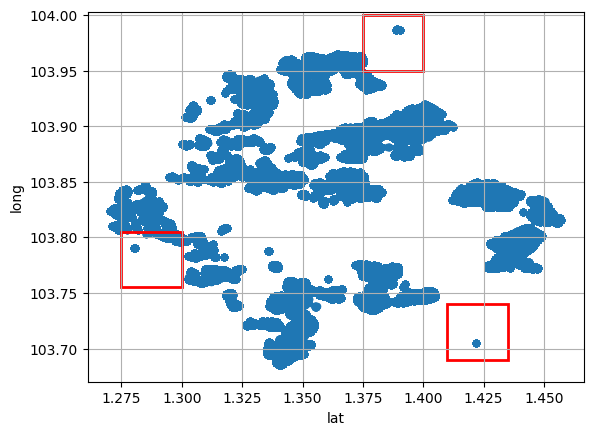

In [155]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
df_combined_geo.plot(x='lat',y='long', kind='scatter', grid=True)
#rect1 = patches.Rectangle((1.3,103.63), 0.025, 0.05, linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((1.41,103.69), 0.025, 0.05, linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((1.375,103.95), 0.025, 0.05, linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((1.275,103.755), 0.025, 0.05, linewidth=2, edgecolor='r', facecolor='none')
#plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)
plt.gca().add_patch(rect4)

In [156]:
df_combined_geo[(df_combined_geo['lat'] > 1.380) & (df_combined_geo['long'] > 103.985)]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
429666,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,120000,2001-10,1980,01 TO 03,4,78,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429667,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,103800,2002-01,1980,04 TO 06,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429668,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,123000,2002-02,1980,01 TO 03,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429669,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,102000,2002-02,1980,04 TO 06,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429670,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,102000,2002-03,1980,01 TO 03,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441626,PASIR RIS,3 ROOM,Improved,67,CHANGI VILLAGE RD,300000,2018-11,1980,04 TO 06,1,60 years 08 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441627,PASIR RIS,3 ROOM,Improved,67,CHANGI VILLAGE RD,270000,2019-08,1980,01 TO 03,1,59 years 11 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441628,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,215000,2019-10,1980,04 TO 06,1,59 years 09 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441629,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,300000,2020-11,1980,01 TO 03,1,58 years 09 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666


In [157]:
df_combined_geo[(df_combined_geo['lat'] > 1.40) & (df_combined_geo['long'] <103.75)]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
50141,CHOA CHU KANG,4 ROOM,Model A,107,CHOA CHU KANG NTH 7,285000,2000-01,1996,01 TO 03,618,95,618 CHOA CHU KANG NTH 7,618 CHOA CHU KANG NORTH 7 SINGAPORE 680618,1.400350,103.746993,yew tee,0.316
50142,CHOA CHU KANG,4 ROOM,Model A,107,CHOA CHU KANG NTH 7,293000,2000-01,1996,10 TO 12,618,95,618 CHOA CHU KANG NTH 7,618 CHOA CHU KANG NORTH 7 SINGAPORE 680618,1.400350,103.746993,yew tee,0.316
50143,CHOA CHU KANG,5 ROOM,Model A,134,CHOA CHU KANG NTH 7,390000,2000-01,1996,04 TO 06,618,95,618 CHOA CHU KANG NTH 7,618 CHOA CHU KANG NORTH 7 SINGAPORE 680618,1.400350,103.746993,yew tee,0.316
50144,CHOA CHU KANG,5 ROOM,Model A,132,CHOA CHU KANG NTH 7,365000,2000-01,1996,01 TO 03,618,95,618 CHOA CHU KANG NTH 7,618 CHOA CHU KANG NORTH 7 SINGAPORE 680618,1.400350,103.746993,yew tee,0.316
50145,CHOA CHU KANG,5 ROOM,Model A,132,CHOA CHU KANG NTH 7,418000,2000-01,1996,07 TO 09,618,95,618 CHOA CHU KANG NTH 7,618 CHOA CHU KANG NORTH 7 SINGAPORE 680618,1.400350,103.746993,yew tee,0.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278267,CHOA CHU KANG,5 ROOM,MODEL A,134,CHOA CHU KANG ST 62,396000,1999-11,1996,01 TO 03,614,96,614 CHOA CHU KANG ST 62,614 CHOA CHU KANG STREET 62 SINGAPORE 680614,1.401067,103.744025,yew tee,0.544
278268,CHOA CHU KANG,5 ROOM,MODEL A,134,CHOA CHU KANG ST 62,400000,1999-11,1996,07 TO 09,614,96,614 CHOA CHU KANG ST 62,614 CHOA CHU KANG STREET 62 SINGAPORE 680614,1.401067,103.744025,yew tee,0.544
278269,CHOA CHU KANG,5 ROOM,IMPROVED,127,CHOA CHU KANG ST 62,385000,1999-12,1996,04 TO 06,614,96,614 CHOA CHU KANG ST 62,614 CHOA CHU KANG STREET 62 SINGAPORE 680614,1.401067,103.744025,yew tee,0.544
278270,CHOA CHU KANG,5 ROOM,MODEL A,131,CHOA CHU KANG ST 62,390000,1999-12,1996,04 TO 06,614,96,614 CHOA CHU KANG ST 62,614 CHOA CHU KANG STREET 62 SINGAPORE 680614,1.401067,103.744025,yew tee,0.544


In [158]:
df_combined_geo[(df_combined_geo['lat'] > 1.375) & (df_combined_geo['long'] > 103.975)]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
429666,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,120000,2001-10,1980,01 TO 03,4,78,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429667,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,103800,2002-01,1980,04 TO 06,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429668,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,123000,2002-02,1980,01 TO 03,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429669,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,102000,2002-02,1980,04 TO 06,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
429670,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,102000,2002-03,1980,01 TO 03,4,77,4 CHANGI VILLAGE RD,4 CHANGI VILLAGE ROAD SINGAPORE 500004,1.389096,103.987463,changi airport,3.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441626,PASIR RIS,3 ROOM,Improved,67,CHANGI VILLAGE RD,300000,2018-11,1980,04 TO 06,1,60 years 08 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441627,PASIR RIS,3 ROOM,Improved,67,CHANGI VILLAGE RD,270000,2019-08,1980,01 TO 03,1,59 years 11 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441628,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,215000,2019-10,1980,04 TO 06,1,59 years 09 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666
441629,PASIR RIS,3 ROOM,Improved,66,CHANGI VILLAGE RD,300000,2020-11,1980,01 TO 03,1,58 years 09 months,1 CHANGI VILLAGE RD,1 NETHERAVON ROAD VILLAGE HOTEL CHANGI SINGAPO...,1.390402,103.986061,changi airport,3.666


In [159]:
# 52 Kent Road became 52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESIDENCES SINGAPORE 118168
df_combined_geo[(df_combined_geo['lat'] < 1.3) & (df_combined_geo['long'] <103.8)]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
89587,KALLANG/WHAMPOA,4 ROOM,New Generation,91,KENT RD,306000,2000-01,1982,04 TO 06,52,81,52 KENT RD,52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESI...,1.280597,103.790460,pasir panjang,0.497
89588,KALLANG/WHAMPOA,4 ROOM,New Generation,91,KENT RD,291000,2000-03,1982,04 TO 06,52,81,52 KENT RD,52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESI...,1.280597,103.790460,pasir panjang,0.497
89589,KALLANG/WHAMPOA,4 ROOM,New Generation,95,KENT RD,285000,2000-05,1982,04 TO 06,52,81,52 KENT RD,52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESI...,1.280597,103.790460,pasir panjang,0.497
89590,KALLANG/WHAMPOA,4 ROOM,New Generation,91,KENT RD,283000,2001-02,1982,01 TO 03,52,80,52 KENT RD,52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESI...,1.280597,103.790460,pasir panjang,0.497
89591,KALLANG/WHAMPOA,4 ROOM,New Generation,91,KENT RD,253000,2001-08,1982,07 TO 09,52,80,52 KENT RD,52 SOUTH BUONA VISTA ROAD KENT RIDGE HILL RESI...,1.280597,103.790460,pasir panjang,0.497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235259,QUEENSTOWN,3 ROOM,STANDARD,52,C'WEALTH DR,120000,1998-08,1970,01 TO 03,69,71,69 C'WEALTH DR,69 COMMONWEALTH DRIVE SINGAPORE 140069,1.299258,103.796157,commonwealth,0.428
235260,QUEENSTOWN,3 ROOM,STANDARD,52,C'WEALTH DR,113500,1999-05,1970,01 TO 03,69,70,69 C'WEALTH DR,69 COMMONWEALTH DRIVE SINGAPORE 140069,1.299258,103.796157,commonwealth,0.428
238677,QUEENSTOWN,3 ROOM,STANDARD,52,C'WEALTH DR,58000,1993-11,1970,01 TO 03,57,76,57 C'WEALTH DR,57 COMMONWEALTH DRIVE SINGAPORE 140057,1.297842,103.796608,commonwealth,0.549
238678,QUEENSTOWN,3 ROOM,STANDARD,52,C'WEALTH DR,63000,1994-08,1970,01 TO 03,57,75,57 C'WEALTH DR,57 COMMONWEALTH DRIVE SINGAPORE 140057,1.297842,103.796608,commonwealth,0.549


In [160]:
df_combined_geo.to_csv('data/hdb_latest.csv', index=False)

# EDA

Questions I want to explore
- Is there a difference pre and post 2000?
  - Distance between MRTs
  - Prices
- What is the most important feature for predicting prices
- How much have price been increasing
- Which district is the most expensive

### Sanity Checks

In [161]:
# Checks whether all addresses have 1 to 1 relationship with the lat and long coordinates
data_path = "data/hdb_latest.csv"
df = pd.read_csv(data_path)
res_lat = df.groupby('address')['lat'].agg([min, max])
res_long = df.groupby('address')['long'].agg([min, max])
assert res_lat['min'].equals(res_lat['max']) == True
assert res_long['min'].equals(res_long['max']) == True

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3301805353.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


## Feature Engineering

In [162]:
from sklearn.model_selection import train_test_split

In [163]:
# we can drop id and lease commence date 
# lease commence date since the feature is already present in remaining lease

In [164]:
df_combined_geo = pd.read_csv(data_path)

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\2287234153.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined_geo = pd.read_csv(data_path)


In [165]:
# make a copy first
df_original = df_combined_geo.copy()

In [166]:
train_df, test_df = train_test_split(df_combined_geo, test_size=TEST_SIZE, random_state=SEED)

In [167]:
train_df.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')

In [168]:
train_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
867136,CHOA CHU KANG,4 ROOM,MODEL A,104.0,CHOA CHU KANG CTRL,273000.0,1999-03,1993,07 TO 09,355,93,355 CHOA CHU KANG CTRL,355 CHOA CHU KANG CENTRAL SINGAPORE 680355,1.383124,103.743775,choa chu kang,0.258
138719,YISHUN,3 ROOM,New Generation,67.0,YISHUN ST 21,160000.0,2007-01,1985,07 TO 09,228,77,228 YISHUN ST 21,228 YISHUN STREET 21 SINGAPORE 760228,1.435337,103.837523,yishun,0.713
555680,PUNGGOL,5 ROOM,Premium Apartment,114.0,PUNGGOL CTRL,515000.0,2011-03,2004,07 TO 09,165B,92,165B PUNGGOL CTRL,165B PUNGGOL CENTRAL SINGAPORE 822165,1.395128,103.914467,riviera,0.201
255400,JURONG EAST,4 ROOM,Simplified,84.0,JURONG EAST ST 21,205000.0,2001-03,1987,10 TO 12,228,85,228 JURONG EAST ST 21,228 JURONG EAST STREET 21 SINGAPORE 600228,1.342575,103.736290,chinese garden,0.411
236167,BEDOK,3 ROOM,New Generation,82.0,BEDOK RESERVOIR RD,212000.0,2000-05,1985,04 TO 06,117,84,117 BEDOK RESERVOIR RD,117 BEDOK RESERVOIR ROAD EUNOS VISTA SINGAPORE...,1.331413,103.908689,kaki bukit,0.396


In [169]:
# Lease commence date has already been processed with current date.
# Address is a combination of block and street name. The Full address is retrieved from onemap sg using address.
train_df.drop(columns=['lease_commence_date','street_name','block','address'], inplace=True)

In [170]:
train_df['remaining_lease'].astype(str).str[:2].astype(int)

867136    93
138719    77
555680    92
255400    85
236167    84
          ..
259178    62
365838    66
131932    94
671155    72
121958    71
Name: remaining_lease, Length: 704091, dtype: int32

In [171]:
# Conversion
train_df['remaining_lease'] = train_df['remaining_lease'].astype(str).str[:2].astype(int)
train_df['floor_area_sqm'] = train_df['floor_area_sqm'].astype(float)
train_df['resale_price'] = train_df['resale_price'].astype(float)
train_df['year'] = pd.to_datetime(train_df['month']).dt.year
train_df['month'] = pd.to_datetime(train_df['month']).dt.month

In [172]:
train_df['postal_code'] = train_df['full_address'].apply(lambda x:x[-6:])

In [173]:
# there are some full addresses that do not have postal codes at the back
train_df['postal_code'] = pd.to_numeric(train_df['postal_code'], errors='coerce')

In [174]:
train_df[train_df['postal_code'].isna()==True]

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,postal_code
99823,QUEENSTOWN,3 ROOM,Improved,59.0,139000.0,7,13 TO 15,75,11351 (BUS STOP) GHIM MOH RD,1.309346,103.789451,buona vista,0.252,2001,NaN
99833,QUEENSTOWN,3 ROOM,Improved,59.0,150000.0,4,13 TO 15,74,11351 (BUS STOP) GHIM MOH RD,1.309346,103.789451,buona vista,0.252,2002,NaN
205312,SERANGOON,4 ROOM,Simplified,84.0,472500.0,4,04 TO 06,67,235 SERANGOON AVENUE 3,1.355105,103.869934,serangoon,0.724,2017,NaN
82125,JURONG WEST,4 ROOM,Model A,109.0,215000.0,5,10 TO 12,92,263 BOON LAY DRIVE,1.345100,103.706912,boon lay,0.728,2002,NaN
306472,PASIR RIS,4 ROOM,Model A,107.0,225000.0,2,01 TO 03,85,253 PASIR RIS STREET 21,1.367995,103.963252,tampines east,1.625,2007,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,ANG MO KIO,3 ROOM,New Generation,68.0,156000.0,11,01 TO 03,73,463 ANG MO KIO AVENUE 10,1.367116,103.857139,ang mo kio,0.899,2006,NaN
251537,HOUGANG,5 ROOM,Improved,123.0,420000.0,3,07 TO 09,83,361 HOUGANG AVENUE 5,1.369245,103.895969,hougang,0.459,2008,NaN
356600,KALLANG/WHAMPOA,4 ROOM,New Generation,135.0,362000.0,6,10 TO 12,81,12 KAMPONG ARANG ROAD,1.300808,103.884077,mountbatten,0.624,2000,NaN
605605,ANG MO KIO,3 ROOM,NEW GENERATION,82.0,57000.0,3,04 TO 06,89,463 ANG MO KIO AVENUE 10,1.367116,103.857139,ang mo kio,0.899,1990,NaN


In [175]:
train_df.dropna(axis=0, inplace=True)

In [176]:
count = 0 
dont_repeat_dict = {}
for idx, postal_code in train_df['postal_code'].reset_index().values:
    if postal_code not in dont_repeat_dict:
        try:
            # cast into int
            int(postal_code)
            dont_repeat_dict[postal_code] = idx
        except Exception as e:
            print(f"Unable to convert {postal_code} at {idx} due to {e}")

In [177]:
train_df.head()

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,postal_code
867136,CHOA CHU KANG,4 ROOM,MODEL A,104.0,273000.0,3,07 TO 09,93,355 CHOA CHU KANG CENTRAL SINGAPORE 680355,1.383124,103.743775,choa chu kang,0.258,1999,680355.0
138719,YISHUN,3 ROOM,New Generation,67.0,160000.0,1,07 TO 09,77,228 YISHUN STREET 21 SINGAPORE 760228,1.435337,103.837523,yishun,0.713,2007,760228.0
555680,PUNGGOL,5 ROOM,Premium Apartment,114.0,515000.0,3,07 TO 09,92,165B PUNGGOL CENTRAL SINGAPORE 822165,1.395128,103.914467,riviera,0.201,2011,822165.0
255400,JURONG EAST,4 ROOM,Simplified,84.0,205000.0,3,10 TO 12,85,228 JURONG EAST STREET 21 SINGAPORE 600228,1.342575,103.736290,chinese garden,0.411,2001,600228.0
236167,BEDOK,3 ROOM,New Generation,82.0,212000.0,5,04 TO 06,84,117 BEDOK RESERVOIR ROAD EUNOS VISTA SINGAPORE...,1.331413,103.908689,kaki bukit,0.396,2000,470117.0


In [178]:
# not all of the full address from the onemap sg contains postal code =(
train_df.reset_index()[train_df.reset_index()['index']==826933]

,index,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,postal_code


In [179]:
for postal_code in list(train_df['postal_code'].unique()):
    try:
        # cast into int
        int(postal_code)
    except Exception as e:
        print(f"Unable to convert {postal_code} due to {e}")

In [183]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702718 entries, 867136 to 121958
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   town                     702718 non-null  object 
 1   flat_type                702718 non-null  object 
 2   flat_model               702718 non-null  object 
 3   floor_area_sqm           702718 non-null  float64
 4   resale_price             702718 non-null  float64
 5   month                    702718 non-null  int64  
 6   storey_range             702718 non-null  object 
 7   remaining_lease          702718 non-null  int32  
 8   full_address             702718 non-null  object 
 9   lat                      702718 non-null  float64
 10  long                     702718 non-null  float64
 11  nearest_mrt              702718 non-null  object 
 12  nearest_distance_to_mrt  702718 non-null  float64
 13  year                     702718 non-null  int64  
 14 

<AxesSubplot: >

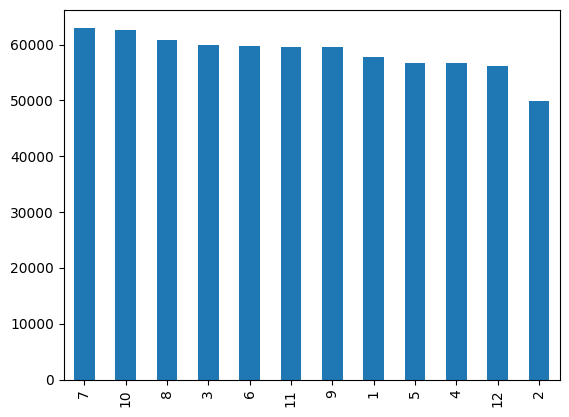

In [184]:
train_df['month'].value_counts().plot(kind= 'bar')

array([[<AxesSubplot: title={'center': 'floor_area_sqm'}>,
        <AxesSubplot: title={'center': 'resale_price'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'remaining_lease'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'long'}>],
       [<AxesSubplot: title={'center': 'nearest_distance_to_mrt'}>,
        <AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'postal_code'}>]], dtype=object)

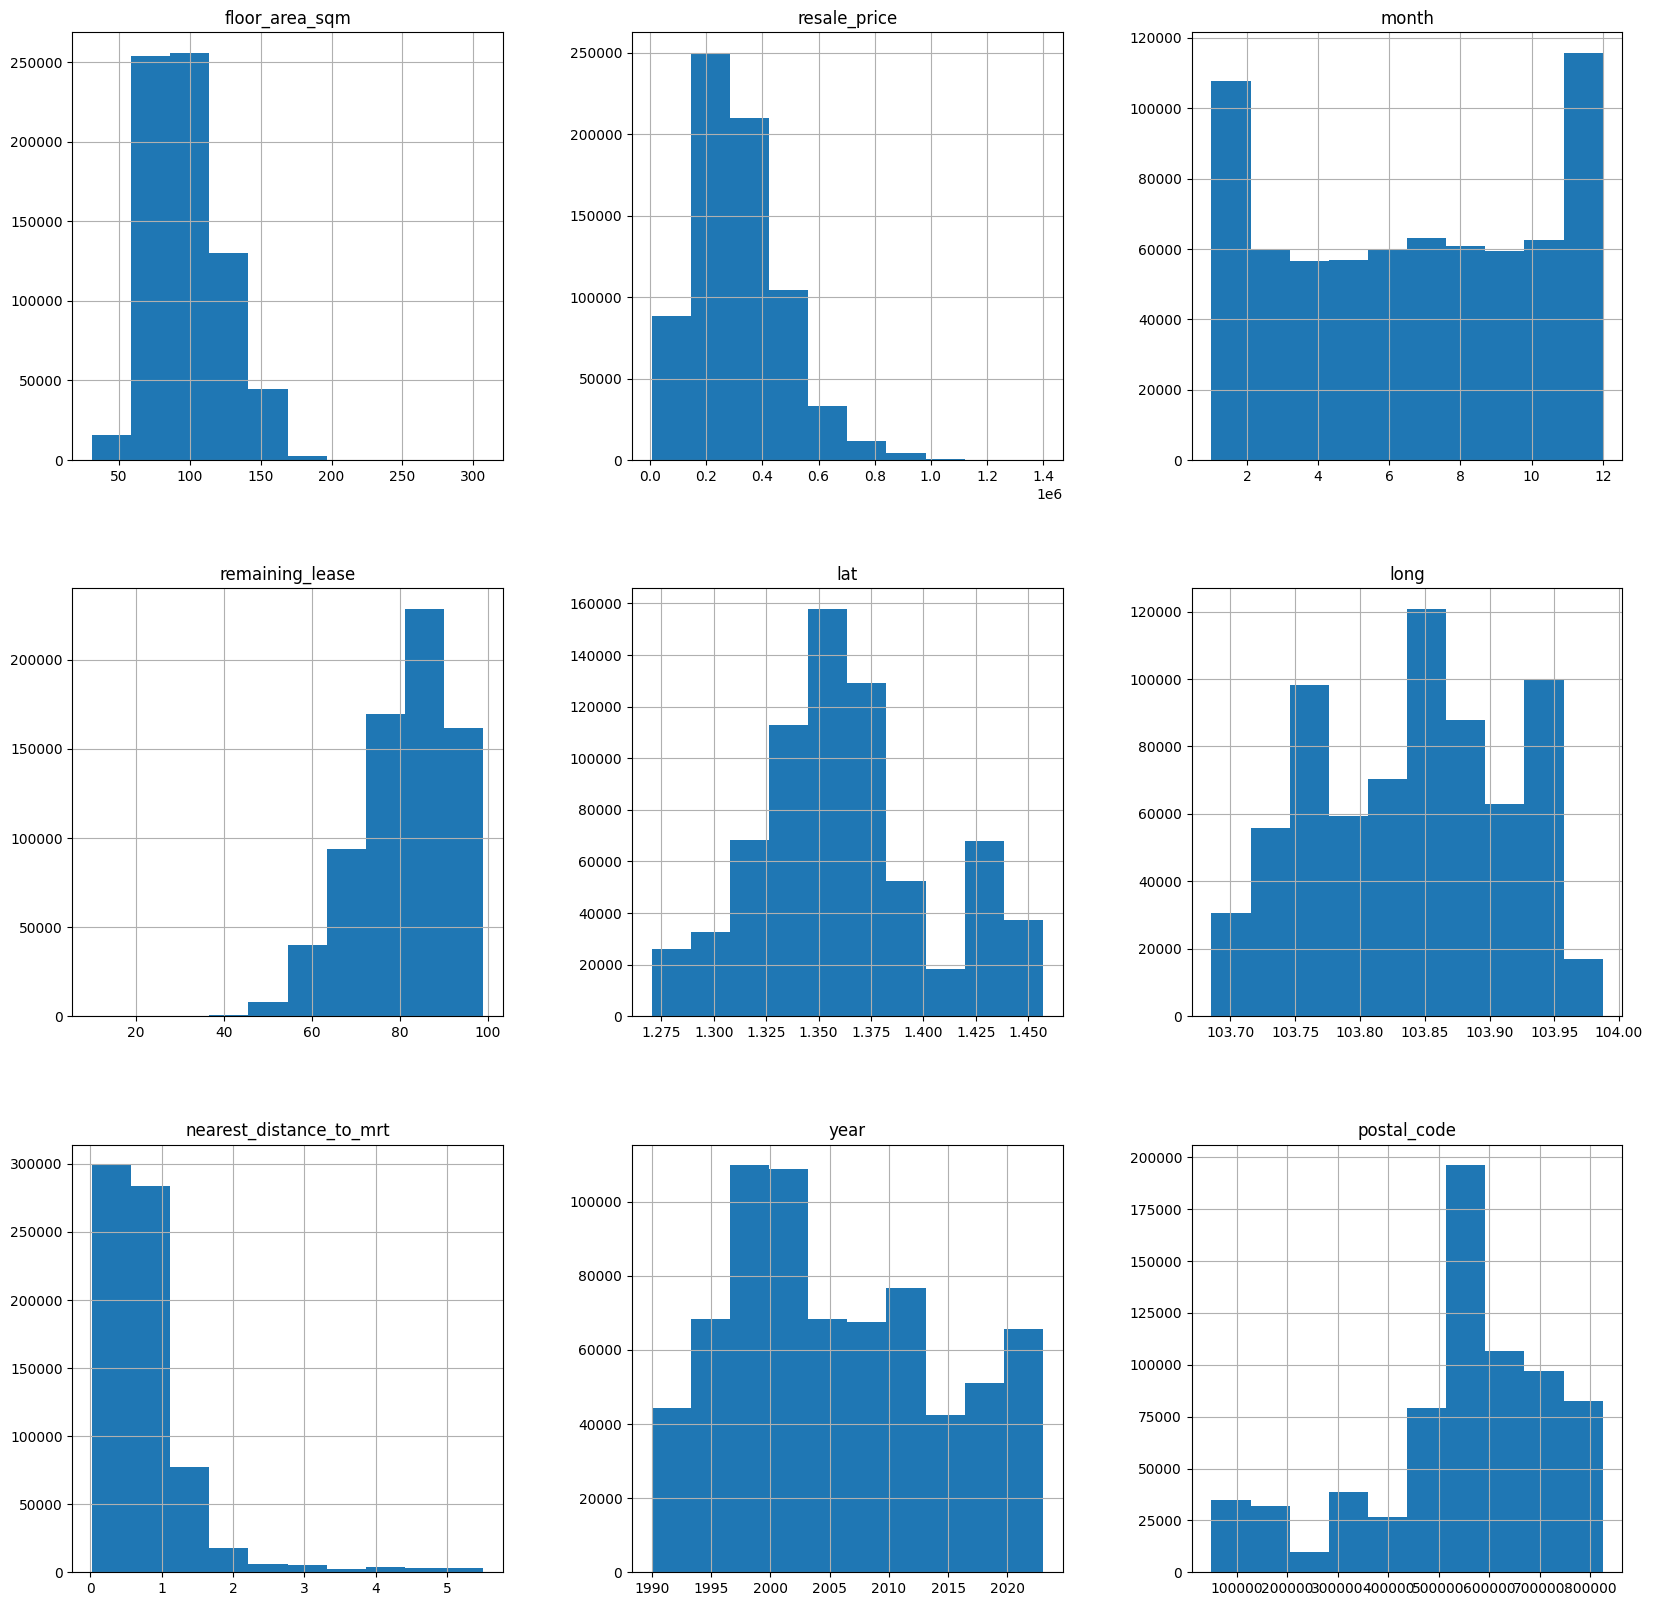

In [185]:
train_df.hist(figsize=(20,20))

In [186]:
train_df.isna().any().all() # No nas

False

Q1 : Is there a difference pre and post 2000 say distance between MRTs and or Prices

In [187]:
post2000_train_df = train_df[train_df['year']>= 2000]
pre2000_train_df = train_df[train_df['year']< 2000]

In [188]:
train_df['year'].value_counts().agg(['idxmax', 'max'])

idxmax     1999
max       45204
Name: year, dtype: int64

In [189]:
train_df.groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,9412
1991,9838
1992,11026
1993,13977
1994,20350
1995,21029
1996,27003
1997,24721
1998,39962


In [190]:
year_most_transactions = train_df['year'].value_counts().idxmax()

In [191]:
train_df

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,postal_code
867136,CHOA CHU KANG,4 ROOM,MODEL A,104.0,273000.0,3,07 TO 09,93,355 CHOA CHU KANG CENTRAL SINGAPORE 680355,1.383124,103.743775,choa chu kang,0.258,1999,680355.0
138719,YISHUN,3 ROOM,New Generation,67.0,160000.0,1,07 TO 09,77,228 YISHUN STREET 21 SINGAPORE 760228,1.435337,103.837523,yishun,0.713,2007,760228.0
555680,PUNGGOL,5 ROOM,Premium Apartment,114.0,515000.0,3,07 TO 09,92,165B PUNGGOL CENTRAL SINGAPORE 822165,1.395128,103.914467,riviera,0.201,2011,822165.0
255400,JURONG EAST,4 ROOM,Simplified,84.0,205000.0,3,10 TO 12,85,228 JURONG EAST STREET 21 SINGAPORE 600228,1.342575,103.736290,chinese garden,0.411,2001,600228.0
236167,BEDOK,3 ROOM,New Generation,82.0,212000.0,5,04 TO 06,84,117 BEDOK RESERVOIR ROAD EUNOS VISTA SINGAPORE...,1.331413,103.908689,kaki bukit,0.396,2000,470117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,KALLANG/WHAMPOA,3 ROOM,Improved,65.0,408000.0,11,13 TO 15,62,16 UPPER BOON KENG ROAD BOON KENG VILLE SINGAP...,1.315432,103.871652,kallang,0.439,2012,380016.0
365838,BUKIT MERAH,4 ROOM,New Generation,92.0,502000.0,10,07 TO 09,66,77 TELOK BLANGAH DRIVE DBS TELOK BLANGAH DRIVE...,1.273954,103.808817,telok blangah,0.376,2011,100077.0
131932,WOODLANDS,5 ROOM,Improved,121.0,267000.0,12,04 TO 06,94,878 WOODLANDS AVENUE 9 SINGAPORE 730878,1.445433,103.791997,woodlands north,0.770,2001,730878.0
671155,TOA PAYOH,3 ROOM,IMPROVED,65.0,83000.0,12,01 TO 03,72,114 LORONG 1 TOA PAYOH TOA PAYOH NORTH SINGAPO...,1.340940,103.844306,braddell,0.282,1994,310114.0


In [192]:
train_df[train_df['nearest_distance_to_mrt']>5].groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,126
1991,172
1992,119
1993,130
1994,224
1995,256
1996,375
1997,399
1998,573


In [193]:
train_df[train_df['nearest_distance_to_mrt']<5].groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,9286
1991,9666
1992,10907
1993,13847
1994,20126
1995,20773
1996,26628
1997,24322
1998,39389


In [194]:
df_combined_geo.select_dtypes(include='object').describe().T

,count,unique,top,freq
town,880114,27,TAMPINES,77721
flat_type,880114,8,4 ROOM,336271
flat_model,880114,34,Model A,180860
street_name,880114,568,YISHUN RING RD,17119
month,880114,398,1999-03,6334
storey_range,880114,25,04 TO 06,221562
block,880114,2658,2,4414
remaining_lease,880114,748,95,26869
address,880114,9576,211 BOON LAY PL,808
full_address,880114,9573,211 BOON LAY PLACE BOON LAY PLACE SINGAPORE 64...,808


In [195]:
df_combined_geo['flat_model'].unique()

array(['Improved', 'Adjoined flat', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Maisonette', 'Model A-Maisonette',
       'Simplified', 'Multi Generation', 'Premium Apartment', 'Terrace',
       '2-room', 'Improved-Maisonette', 'Premium Maisonette', 'Model A2',
       'DBSS', 'Type S1', 'Type S2', 'Premium Apartment Loft', '3Gen',
       'NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', '2-ROOM',
       'TERRACE', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT'], dtype=object)

In [196]:
df_combined_geo['flat_type'].unique()

array(['3 ROOM', '2 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION', '1 ROOM', 'MULTI GENERATION'], dtype=object)

In [197]:
df_combined_geo['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'GEYLANG', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA',
       'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG', 'JURONG EAST', 'YISHUN',
       'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS',
       'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS',
       'SEMBAWANG', 'SENGKANG', 'PUNGGOL', 'LIM CHU KANG'], dtype=object)

In [198]:
df_combined_geo['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '01 TO 05',
       '06 TO 10', '13 TO 15', '11 TO 15', '22 TO 24', '19 TO 21',
       '16 TO 18', '25 TO 27', '21 TO 25', '16 TO 20', '28 TO 30',
       '26 TO 30', '31 TO 33', '37 TO 39', '34 TO 36', '40 TO 42',
       '31 TO 35', '36 TO 40', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

[Text(0, 0, 'CHOA CHU KANG'),
 Text(1, 0, 'YISHUN'),
 Text(2, 0, 'PUNGGOL'),
 Text(3, 0, 'JURONG EAST'),
 Text(4, 0, 'BEDOK'),
 Text(5, 0, 'SENGKANG'),
 Text(6, 0, 'WOODLANDS'),
 Text(7, 0, 'TOA PAYOH'),
 Text(8, 0, 'ANG MO KIO'),
 Text(9, 0, 'CLEMENTI'),
 Text(10, 0, 'PASIR RIS'),
 Text(11, 0, 'KALLANG/WHAMPOA'),
 Text(12, 0, 'TAMPINES'),
 Text(13, 0, 'BUKIT BATOK'),
 Text(14, 0, 'BUKIT MERAH'),
 Text(15, 0, 'QUEENSTOWN'),
 Text(16, 0, 'MARINE PARADE'),
 Text(17, 0, 'SERANGOON'),
 Text(18, 0, 'JURONG WEST'),
 Text(19, 0, 'HOUGANG'),
 Text(20, 0, 'BISHAN'),
 Text(21, 0, 'SEMBAWANG'),
 Text(22, 0, 'GEYLANG'),
 Text(23, 0, 'CENTRAL AREA'),
 Text(24, 0, 'BUKIT PANJANG'),
 Text(25, 0, 'BUKIT TIMAH'),
 Text(26, 0, 'LIM CHU KANG')]

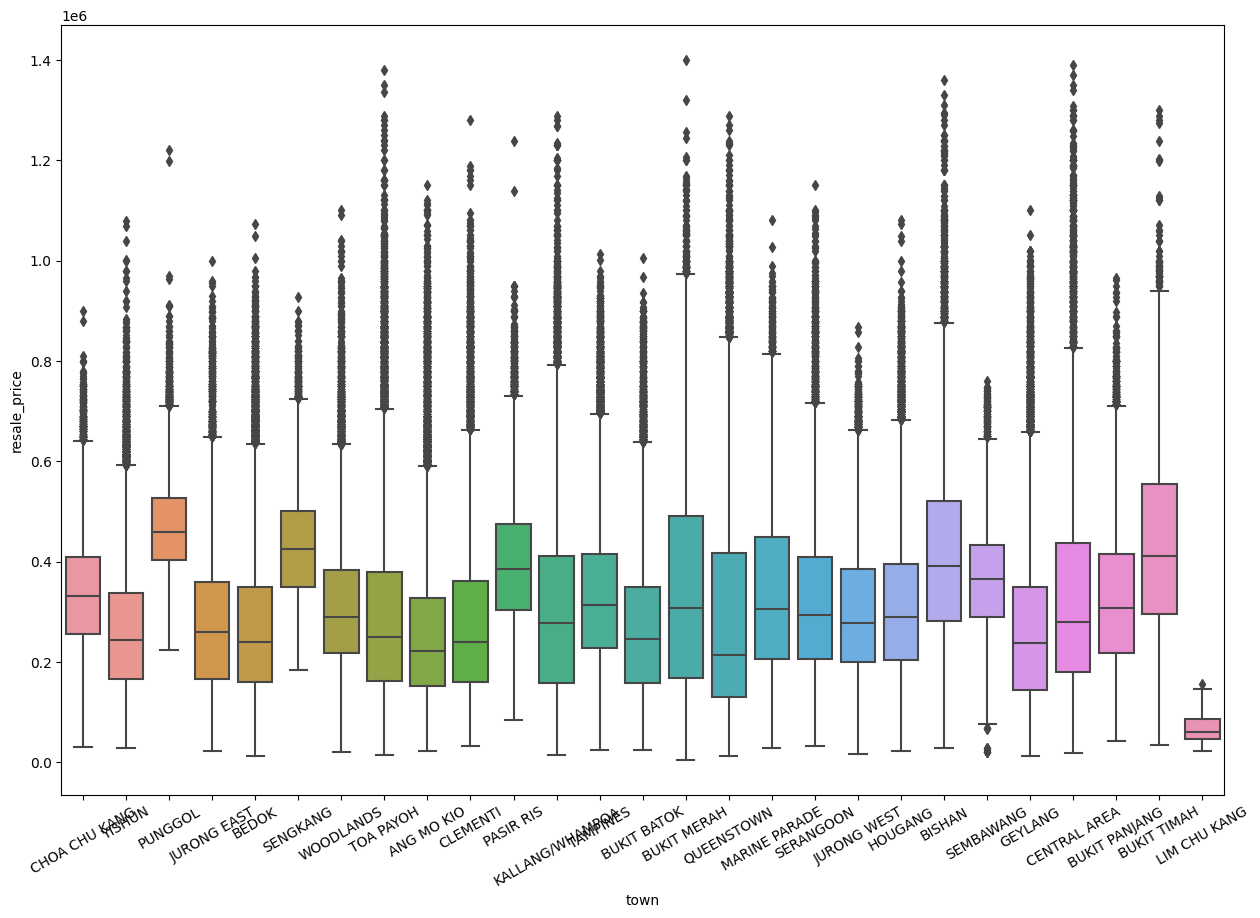

In [199]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,10))
ax = sns.boxplot(x='town', y='resale_price', data=train_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Price Trend

In [200]:
trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\1983881809.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)


In [201]:
trend_df

,floor_area_sqm,resale_price,remaining_lease,nearest_distance_to_mrt
,mean,mean,mean,mean
year,,,,
1990,85.05,69933.98,88.78,1.07
1991,86.86,75340.99,88.63,1.13
1992,88.62,86037.20,88.12,1.10
1993,92.02,135244.93,87.91,1.12
1994,93.25,175578.83,87.59,1.13
1995,93.36,215046.47,86.95,1.14
1996,92.03,282939.33,86.26,1.18
1997,96.15,311812.14,86.12,1.17


In [202]:
trend_df['floor_area_sqm'].idxmax().values[0]

1999

In [203]:
def print_max_min(col:str, max_min:str)->None:
    if max_min == 'max':
        res = f"Year with highest mean {col} : {trend_df[col].idxmax().values[0]} of {trend_df[col].max().values[0]}"
    elif max_min == 'min':
        res = f"Year with lowest mean {col} : {trend_df[col].idxmin().values[0]} of {trend_df[col].min().values[0]}"
    else:
        print('Please either indicate max or min')
    print(res)

In [204]:
print(f"Year with highest floor_area_sqm : {trend_df['floor_area_sqm'].idxmax().values[0]} of {trend_df['floor_area_sqm'].max().values[0]}")

Year with highest floor_area_sqm : 1999 of 99.08


In [205]:
for col , _ in trend_df.select_dtypes(exclude='object').columns:
    for metric in ['max', 'min']:
        print_max_min(col, metric)

Year with highest mean floor_area_sqm : 1999 of 99.08
Year with lowest mean floor_area_sqm : 1990 of 85.05
Year with highest mean resale_price : 2023 of 558054.16
Year with lowest mean resale_price : 1990 of 69933.98
Year with highest mean remaining_lease : 1990 of 88.78
Year with lowest mean remaining_lease : 2023 of 73.55
Year with highest mean nearest_distance_to_mrt : 1998 of 1.19
Year with lowest mean nearest_distance_to_mrt : 2021 of 0.59


C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3635810421.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))


([<matplotlib.axis.XTick at 0x1ffbaff31f0>,
 [Text(1990, 0, '1990'),
  Text(1991, 0, '1991'),
  Text(1992, 0, '1992'),
  Text(1993, 0, '1993'),
  Text(1994, 0, '1994'),
  Text(1995, 0, '1995'),
  Text(1996, 0, '1996'),
  Text(1997, 0, '1997'),
  Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022')])

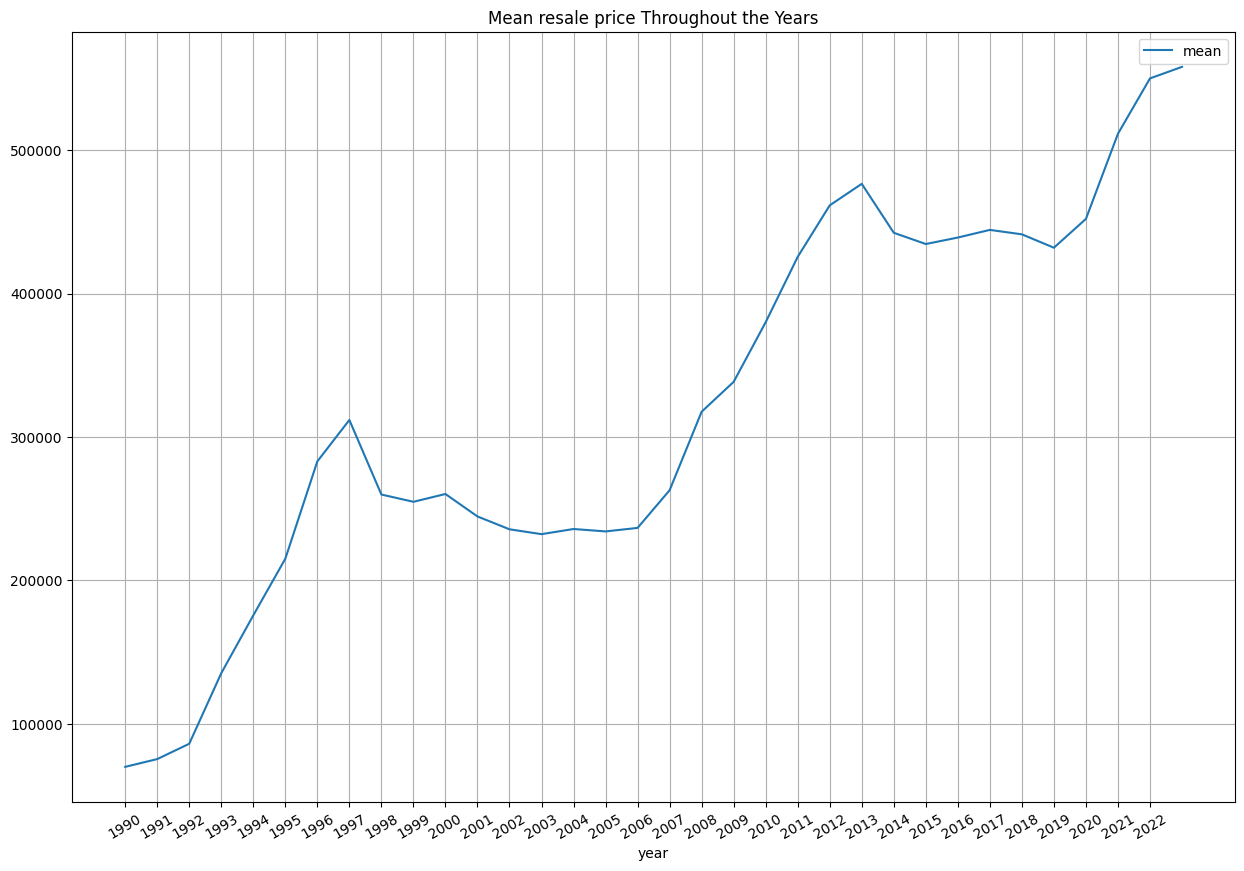

In [206]:
train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))
plt.xticks(range(1990,2023), rotation = 30)

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\907755644.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))


([<matplotlib.axis.XTick at 0x1ffc5437d90>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

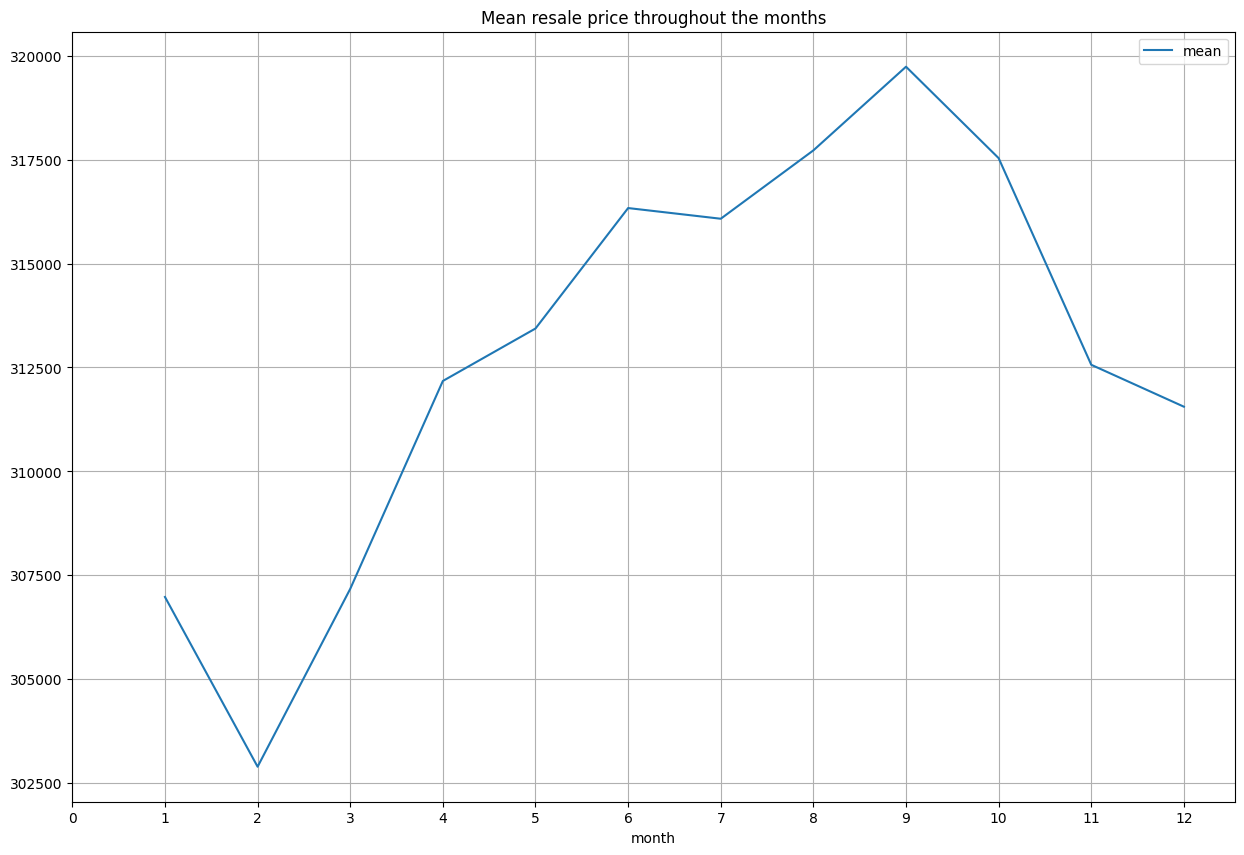

In [207]:
train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))
# figure = plt.gcf()
plt.xticks(range(0,13))

# Test Script

In [208]:
from hdb_mrt import mrt_onemap
from hdb_mrt import hdb
import pandas as pd

In [209]:
limit = 500000
resource_post2017 = "f1765b54-a209-4718-8d38-a39237f502b3"
resource_jan2015todec2016 = "1b702208-44bf-4829-b620-4615ee19b57c"
resource_mar2012todec2014 = "83b2fc37-ce8c-4df4-968b-370fd818138b"
resource_jan2000tofeb2012 = "8c00bf08-9124-479e-aeca-7cc411d884c4"
resource_pre1999 = "adbbddd3-30e2-445f-a123-29bee150a6fe"
data_gov_api = "https://data.gov.sg/api/action/datastore_search?"
onemap_api = "https://developers.onemap.sg/commonapi/search"
mrt_api = "https://datamall.lta.gov.sg/content/dam/datamall/datasets/PublicTransportRelated/Train%20Station%20Codes%20and%20Chinese%20Names.zip"
mrt_excel_file = "Train Station Codes and Chinese Names.xls"

urls = [
    resource_pre1999,
    resource_jan2000tofeb2012, 
    resource_mar2012todec2014,
    resource_jan2015todec2016, 
    resource_post2017 
    ]


In [210]:
hdb_df = hdb.retrieve_records(data_gov_api, urls, limit)

In [211]:
hdb_df['street_name'] = hdb_df['street_name'].where(hdb_df['street_name']!='MARINE CRES','MARINE CRESCENT VILLE')
unique_address = hdb_df['address'].unique()

In [212]:
# logging.info("Done retrieving all HDB records and generating unique address")
# This takes around 13 mins
geo_details = mrt_onemap.return_geo_many_address(onemap_api , unique_address)
unique_address_geo = []

#TODO: use tqdm to give an estimate on the amount of time or entries needed till completion



In [213]:
# logging.info("Attempting to retrieve unique addresses geo data from onemap sg ...")
for idx, address in enumerate(unique_address):
    unique_address_geo.append([address, geo_details[idx][0],geo_details[idx][1],geo_details[idx][2]])
unique_address_geo_pd = pd.DataFrame(unique_address_geo)
unique_address_geo_pd.columns = ('address','full_address','lat','long')
# logging.info("Done retrieving unique addresses geo data")

In [214]:
unique_address_geo_pd_valid = unique_address_geo_pd[unique_address_geo_pd['full_address'] != 'na']
unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3664722500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3664722500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')


In [215]:
non_valid_addresses = [address for address in hdb_df.address.values if address in unique_address_geo_pd[unique_address_geo_pd['full_address'] == 'na'].values]

In [216]:
pre2000_hdb = hdb.retrieve_record(data_gov_api, resource_pre1999, limit, add_remaining_lease=True)
yr2000to2012_hdb = hdb.retrieve_record(data_gov_api, resource_jan2000tofeb2012,limit,add_remaining_lease=True)
yr2012to2014_hdb = hdb.retrieve_record(data_gov_api, resource_mar2012todec2014,limit,add_remaining_lease=True)
yr2015to2016_hdb = hdb.retrieve_record(data_gov_api, resource_jan2015todec2016,limit)
post2017_hdb = hdb.retrieve_record(data_gov_api, resource_post2017,limit)

In [217]:
yr2012to2014_hdb

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,address,remaining_lease
0,ANG MO KIO,2 ROOM,Improved,45,ANG MO KIO AVE 4,250000,2012-03,1986,06 TO 10,1,172,172 ANG MO KIO AVE 4,73
1,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 8,265000,2012-03,1980,01 TO 05,2,510,510 ANG MO KIO AVE 8,67
2,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 4,315000,2012-03,1980,06 TO 10,3,610,610 ANG MO KIO AVE 4,67
3,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 10,320000,2012-03,1984,01 TO 05,4,474,474 ANG MO KIO AVE 10,71
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,321000,2012-03,1980,06 TO 10,5,604,604 ANG MO KIO AVE 5,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52198,YISHUN,5 ROOM,Improved,122,YISHUN ST 81,580000,2014-12,1988,10 TO 12,52199,816,816 YISHUN ST 81,73
52199,YISHUN,EXECUTIVE,Maisonette,146,YISHUN CTRL,540000,2014-12,1988,10 TO 12,52200,325,325 YISHUN CTRL,73
52200,YISHUN,EXECUTIVE,Apartment,164,YISHUN RING RD,738000,2014-12,1992,07 TO 09,52201,618,618 YISHUN RING RD,77
52201,YISHUN,EXECUTIVE,Maisonette,152,YISHUN ST 22,592000,2014-12,1985,07 TO 09,52202,277,277 YISHUN ST 22,70


In [218]:
stations = mrt_onemap.extract_mrt_excelsheet(mrt_api,mrt_excel_file)


In [219]:
stations_pd = mrt_onemap.return_mrt_with_geo(onemap_api ,stations)

In [220]:
stations_pd

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [221]:
unique_address_geo_pd_valid = unique_address_geo_pd[unique_address_geo_pd['full_address'] != 'na']
unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')

C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3842435388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['lat'] = unique_address_geo_pd_valid['lat'].astype('float')
C:\Users\Randy\AppData\Local\Temp\ipykernel_21940\3842435388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_address_geo_pd_valid['long'] = unique_address_geo_pd_valid['long'].astype('float')


In [222]:
pre_2000_mrt_lines = ['ns', 'ew'] # or the OG green and red lines
pattern = '|'.join(pre_2000_mrt_lines)

In [223]:
stations_pd

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [224]:
stations_pre_2000 =  stations_pd[stations_pd['stn_code'].str.contains(pattern)]

In [225]:
unique_address_geo_pd_valid_mrt_pre_2000 = mrt_onemap.return_closest_mrt_distances(unique_address_geo_pd_valid, stations_pre_2000)
unique_address_geo_pd_valid_mrt = mrt_onemap.return_closest_mrt_distances(unique_address_geo_pd_valid, stations_pd)


In [226]:
unique_address_geo_pd_valid_mrt.columns = ('address', 'full_address','lat','long','nearest_mrt','nearest_distance_to_mrt')
unique_address_geo_pd_valid_mrt_pre_2000.columns = ('address', 'full_address','lat','long','nearest_mrt','nearest_distance_to_mrt')


In [227]:
pre2000_hdb_valid = pre2000_hdb[~pre2000_hdb['address'].isin(non_valid_addresses)]
pre2000_hdb_valid_w_geo = pre2000_hdb_valid.merge(unique_address_geo_pd_valid_mrt_pre_2000, left_on='address', right_on='address')

post2000_hdb=pd.concat([yr2000to2012_hdb,yr2012to2014_hdb,yr2015to2016_hdb,post2017_hdb], axis=0)
post2000_hdb_valid = post2000_hdb[~post2000_hdb['address'].isin(non_valid_addresses)]
post2000_hdb_valid_w_geo = post2000_hdb_valid.merge(unique_address_geo_pd_valid_mrt, left_on='address', right_on='address')

hdb_df_geo = pd.concat([post2000_hdb_valid_w_geo, pre2000_hdb_valid_w_geo], axis=0)
hdb_df_geo.drop(columns='_id', inplace=True)

In [228]:
hdb_df_geo.equals(df_combined_geo)

False

In [229]:
hdb_df_geo.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,address,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69,ANG MO KIO AVE 4,147000,2000-01,1986,07 TO 09,170,170 ANG MO KIO AVE 4,85,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60,ANG MO KIO AVE 4,130000,2000-02,1986,07 TO 09,170,170 ANG MO KIO AVE 4,85,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45,ANG MO KIO AVE 4,105000,2000-03,1986,04 TO 06,170,170 ANG MO KIO AVE 4,85,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,ANG MO KIO,2 ROOM,Improved,45,ANG MO KIO AVE 4,125000,2000-05,1986,04 TO 06,170,170 ANG MO KIO AVE 4,85,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,ANG MO KIO,2 ROOM,Improved,45,ANG MO KIO AVE 4,117000,2000-06,1986,07 TO 09,170,170 ANG MO KIO AVE 4,85,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


In [230]:
df_combined_geo.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,125000.0,2000-05,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,117000.0,2000-06,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


# Data Prep

List of all transformations done (to be done) on dataset:
- town : OHE
- flat_type : OHE
- flat_model : OHE
- floor_area_sqm : standard scaling
- street_name : dropped
- resale_price : target, no change
- month : split into year and month with month overwritting column's values
- lease_commence_date : drop
- storey_range : Ordinal Encode
- block : dropped
- address : dropped
- remaining_lease : standard scaling
- full_address : dropped
- lat : standard scaling
- long : standard scaling
- nearest_mrt : OHE
- nearest_distance_to_mrt : standard scaling

In [330]:
train_df , test_df = train_test_split(hdb_df_geo, test_size=TEST_SIZE, random_state=SEED)

In [331]:
train_df.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'address', 'remaining_lease', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')

In [332]:
# ordinal_ranking_flat_type = ['MULTI-GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12','11 TO 15', '13 TO 15',
        '16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30',
       '31 TO 33','31 TO 35','34 TO 36',  '37 TO 39', '36 TO 40', '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

In [334]:
class Conversion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['remaining_lease'] = X['remaining_lease'].astype(str).str[:2].astype(int)
        X['floor_area_sqm'] = X['floor_area_sqm'].astype(float)
        return X

In [335]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

ORDINAL_FEATURES = ["storey_range"]
CAT_FEATURES = ["town", "nearest_mrt", "flat_model","flat_type"]
NUM_FEATURES = ["remaining_lease","floor_area_sqm","month", "year", "lat", "long","nearest_distance_to_mrt"]
POSSIBLE_NA_FEATURES = ["postal_code"]
TARGET = "resale_price"

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, year:bool = True, month:bool = True,postal_code:bool = True) -> None:
        self.year = year
        self.month = month
        self.postal_code = postal_code
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.year:
            X['year'] = pd.to_datetime(X['month']).dt.year
        if self.month:
            X['month'] = pd.to_datetime(X['month']).dt.month
        if self.postal_code:
            X['postal_code'] = X['full_address'].apply(lambda x:x[-6:])
            X['postal_code'] = pd.to_numeric(X['postal_code'], errors='coerce')
            X['postal_code'].fillna(0, axis=0, inplace=True)
            X['postal_code'] = X['postal_code'].astype(int)
        return X

In [336]:
ordinal_pipe = OrdinalEncoder(categories=[ordinal_ranking_storey_range])
cat_pipe = OneHotEncoder(drop='first', sparse=False)
num_pipe = StandardScaler()
convert_pipe = Conversion()
addfeature_pipe = AddFeatures()
simpleimputer = SimpleImputer(strategy="median")

column_pipe = ColumnTransformer([
    ('cat_pipe',cat_pipe , CAT_FEATURES),
    ('num_pipe',num_pipe, NUM_FEATURES),
    ('ordinal_pipe', ordinal_pipe, ORDINAL_FEATURES),
    ('imputer', simpleimputer, POSSIBLE_NA_FEATURES)
    ], remainder='drop')

add_features_pipe = Pipeline([
    ('add_features', addfeature_pipe),
    ('conversion', convert_pipe)
])

datapipe = Pipeline([
    ('add_features_conversion', add_features_pipe),
    ('column_transformer', column_pipe)
])

In [337]:
y = train_df.pop(TARGET)

In [338]:
X = train_df

In [339]:
X.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,month,lease_commence_date,storey_range,block,address,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
252647,WOODLANDS,4 ROOM,MODEL A,103,WOODLANDS ST 31,1998-08,1993,04 TO 06,311,311 WOODLANDS ST 31,94,311 WOODLANDS STREET 31 SINGAPORE 730311,1.430459,103.776170,marsiling,0.327
221012,WOODLANDS,4 ROOM,Simplified,84,WOODLANDS AVE 3,2000-08,1988,04 TO 06,347,347 WOODLANDS AVE 3,87,347 WOODLANDS AVENUE 3 MY FIRST SKOOL SINGAPOR...,1.433178,103.781595,woodlands,0.641
221073,WOODLANDS,4 ROOM,Simplified,84,WOODLANDS AVE 3,2019-11,1988,10 TO 12,347,347 WOODLANDS AVE 3,67 years 06 months,347 WOODLANDS AVENUE 3 MY FIRST SKOOL SINGAPOR...,1.433178,103.781595,woodlands,0.641
344104,YISHUN,4 ROOM,Model A,105,YISHUN RING RD,2008-09,1989,01 TO 03,353,353 YISHUN RING RD,80,353 YISHUN RING ROAD YISHUN JASMINE SINGAPORE ...,1.426137,103.845216,yishun,1.193
82125,ANG MO KIO,4 ROOM,NEW GENERATION,92,ANG MO KIO AVE 10,1998-04,1979,10 TO 12,470,470 ANG MO KIO AVE 10,80,470 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,1.364098,103.856694,ang mo kio,1.025


In [340]:
X.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'month', 'lease_commence_date', 'storey_range', 'block', 'address',
       'remaining_lease', 'full_address', 'lat', 'long', 'nearest_mrt',
       'nearest_distance_to_mrt'],
      dtype='object')

In [341]:
X_transform = datapipe.fit_transform(X)

c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Modelling

In [357]:
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, year:bool = True, month:bool = True,postal_code:bool = True) -> None:
        self.year = year
        self.month = month
        self.postal_code = postal_code
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.year:
            X['year'] = pd.to_datetime(X['month']).dt.year
        if self.month:
            X['month'] = pd.to_datetime(X['month']).dt.month
        if self.postal_code:
            X['postal_code'] = X['full_address'].apply(lambda x:x[-6:])
            X['postal_code'] = pd.to_numeric(X['postal_code'], errors='coerce')
            X['postal_code'].fillna(0, axis=0, inplace=True)
            X['postal_code'] = X['postal_code'].astype(int)
        return X

class Conversion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['remaining_lease'] = X['remaining_lease'].astype(str).str[:2].astype(int)
        X['floor_area_sqm'] = X['floor_area_sqm'].astype(float)
        return X

class DataPipeline_test():

    def __init__(self, addfeature:bool = True,seed:int=42,test_size:float=0.33):
        self.test_size = test_size
        self.seed = seed
        self.ORDINAL_FEATURES = ["storey_range"]
        self.CAT_FEATURES = ["town", "nearest_mrt", "flat_model","flat_type"]
        self.NUM_FEATURES = ["remaining_lease","floor_area_sqm","month", "year",\
             "lat", "long", "postal_code","nearest_distance_to_mrt"]
        self.TARGET = "resale_price"
        self.POSSIBLE_NA_FEATURE = ["postal_code"]
        self.ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12','11 TO 15', '13 TO 15',
        '16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30',
       '31 TO 33','31 TO 35','34 TO 36',  '37 TO 39', '36 TO 40', '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

        self.ordinal_pipe = OrdinalEncoder(categories=[self.ordinal_ranking_storey_range])
        self.cat_pipe = OneHotEncoder(drop='first', sparse=False)
        self.num_pipe = StandardScaler()
        self.convert_pipe = Conversion()
        self.addfeature_pipe = AddFeatures()
        self.simpleimputer = SimpleImputer(strategy="median")

        if addfeature==False:
            self.NUM_FEATURES.remove('postal_code')
            self.NUM_FEATURES.remove('year')

        column_pipe = ColumnTransformer([
            ('cat_pipe',self.cat_pipe , self.CAT_FEATURES),
            ('num_pipe',self.num_pipe, self.NUM_FEATURES),
            ('ordinal_pipe', self.ordinal_pipe, self.ORDINAL_FEATURES)
            ], remainder='drop')

        add_features_pipe = Pipeline([
            ('add_features', self.addfeature_pipe),
            ('conversion', self.convert_pipe)
        ])

        if addfeature:
            self.datapipe = Pipeline([
                ('add_features_conversion', add_features_pipe),
                ('column_transformer', column_pipe)
            ]) 

        else:
            self.datapipe = Pipeline([
                ('conversion', self.convert_pipe),
                ('column_transformer', column_pipe)
            ]) 

    def _split(self, df:pd.DataFrame):
        y = df.pop(self.TARGET)
        X = df


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, \
            random_state=self.seed)

        return X_train, X_test, y_train, y_test

    def _run_ct(self, X_train, X_test):
        X_train = self.datapipe.fit_transform(X_train)
        X_test = self.datapipe.transform(X_test)

        return X_train, X_test

    def transform(self, df, y= None):
        """preprocess, transform and then split the dataset

        Parameters
        ----------
        X : pd.DataFrame
            the entire DataFrame
        y : None, Ignored
        """
        X_train, X_test, y_train, y_test = self._split(df)

        X_train, X_test = self._run_ct(X_train, X_test)

        return X_train, X_test, y_train, y_test


In [358]:
df_original_copy  = df_original.copy()

In [359]:
datapipeline = DataPipeline_test()
X_train, X_test, y_train, y_test = datapipeline.transform(df_original_copy)

c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [360]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
from src.datapipeline import DataPipeline

df_original_copy_2 = df_original.copy()

datapipeline = DataPipeline()
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = datapipeline.transform(df_original_copy_2)

c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [362]:
# Check to see if the datapipeline yields the same results

In [363]:
np.array_equal(X_train, X_train_pipe)

True

In [364]:
np.array_equal(X_test, X_test_pipe)

True

In [365]:
np.array_equal(y_train, y_train_pipe)

True

In [366]:
np.array_equal(y_test, y_test_pipe)

True

In [367]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [368]:
X_train.shape

(589676, 210)

In [369]:
y_train.shape

(589676,)

In [370]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = (mse)**(1/2)

print(rmse)

60309.34624328226


In [371]:
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor(), DecisionTreeRegressor()]

In [372]:
dict_results = {}

def train_model(model, X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = (mse)**(1/2)

    print(f"Model used is {model}")
    print(f"Rmse is {rmse}")
    print(f"Mae is {mae}")
    return model, rmse , mae

In [373]:
for model in models:
    model_fit, rsme, mae = train_model(model, X_train, y_train, X_test, y_test)
    dict_results[model] = {'fitted model':model_fit, 'RMSE': rmse, 'MAE': mae}

Model used is LinearRegression()
Rmse is 60309.34624328226
Mae is 46259.91790327884


c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.471e+14, tolerance: 1.539e+12
  model = cd_fast.enet_coordinate_descent(


Model used is Lasso()
Rmse is 60329.303781936505
Mae is 46261.23861164992
Model used is Ridge()
Rmse is 60309.12820838921
Mae is 46256.71518390116
Model used is ElasticNet()
Rmse is 87369.99788578485
Mae is 64817.59789865745
